# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-mc'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5482, Accuracy: 0.8235, F1 Micro: 0.3957, F1 Macro: 0.1089
Epoch 2/10, Train Loss: 0.4449, Accuracy: 0.8261, F1 Micro: 0.3948, F1 Macro: 0.1114
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4226, Accuracy: 0.8427, F1 Micro: 0.425, F1 Macro: 0.1296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3956, Accuracy: 0.8722, F1 Micro: 0.5404, F1 Macro: 0.2483
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3615, Accuracy: 0.8882, F1 Micro: 0.6223, F1 Macro: 0.319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.8876, F1 Micro: 0.6674, F1 Macro: 0.3992
Epoch 7/10, Train Loss: 0.2921, Accuracy: 0.8962, F1 Micro: 0.6533, F1 Macro: 0.4217
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2596, Accuracy: 0.8949, F1 Micro: 0.6917, F1 Macro: 0.4934
Epoch 9/10, Train Loss: 0.2337, Accuracy: 0.9006, F1 Micro: 0.6899, F1 Macro: 0.505
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.518, Accuracy: 0.8248, F1 Micro: 0.3987, F1 Macro: 0.1069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4332, Accuracy: 0.8275, F1 Micro: 0.407, F1 Macro: 0.1183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4016, Accuracy: 0.8479, F1 Micro: 0.5761, F1 Macro: 0.2925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3728, Accuracy: 0.8887, F1 Micro: 0.662, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3253, Accuracy: 0.9014, F1 Micro: 0.6843, F1 Macro: 0.4737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2791, Accuracy: 0.9025, F1 Micro: 0.7112, F1 Macro: 0.5273
Epoch 7/10, Train Loss: 0.2441, Accuracy: 0.9058, F1 Micro: 0.7083, F1 Macro: 0.5341
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2042, Accuracy: 0.9072, F1 Micro: 0.7129, F1 Macro: 0.5347
Epoch 9/10, Train Loss: 0.1849, Accuracy: 0.9069, F1 Micro: 0.7099, F1 Macro: 0.5495
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.499, Accuracy: 0.8237, F1 Micro: 0.4068, F1 Macro: 0.1076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4245, Accuracy: 0.8429, F1 Micro: 0.4605, F1 Macro: 0.1755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3862, Accuracy: 0.888, F1 Micro: 0.657, F1 Macro: 0.3832
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3327, Accuracy: 0.9003, F1 Micro: 0.7019, F1 Macro: 0.4936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2919, Accuracy: 0.9058, F1 Micro: 0.708, F1 Macro: 0.5386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2413, Accuracy: 0.9084, F1 Micro: 0.719, F1 Macro: 0.558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2044, Accuracy: 0.9116, F1 Micro: 0.726, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1683, Accuracy: 0.9099, F1 Micro: 0.7384, F1 Macro: 0.5959
Epoch 9/10, Train Loss: 0.1449, Accuracy: 0.9092, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4938, Accuracy: 0.8247, F1 Micro: 0.4007, F1 Macro: 0.1112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4158, Accuracy: 0.8598, F1 Micro: 0.5019, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3742, Accuracy: 0.894, F1 Micro: 0.6814, F1 Macro: 0.4568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3277, Accuracy: 0.9047, F1 Micro: 0.7133, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.283, Accuracy: 0.9044, F1 Micro: 0.7281, F1 Macro: 0.5466
Epoch 6/10, Train Loss: 0.243, Accuracy: 0.9136, F1 Micro: 0.7269, F1 Macro: 0.546
Epoch 7/10, Train Loss: 0.2012, Accuracy: 0.9135, F1 Micro: 0.7274, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1704, Accuracy: 0.9148, F1 Micro: 0.7435, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462, Accuracy: 0.9164, F1 Micro: 0.746, F1 Macro: 0.6183
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4828, Accuracy: 0.8239, F1 Micro: 0.4491, F1 Macro: 0.1644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.407, Accuracy: 0.8723, F1 Micro: 0.6161, F1 Macro: 0.3406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.35, Accuracy: 0.9043, F1 Micro: 0.7046, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.306, Accuracy: 0.9072, F1 Micro: 0.7317, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2648, Accuracy: 0.9137, F1 Micro: 0.7341, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2213, Accuracy: 0.9146, F1 Micro: 0.743, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1818, Accuracy: 0.9147, F1 Micro: 0.749, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1565, Accuracy: 0.9167, F1 Micro: 0.7507, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1341

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4794, Accuracy: 0.8304, F1 Micro: 0.4515, F1 Macro: 0.1719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.8843, F1 Micro: 0.6598, F1 Macro: 0.3927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.336, Accuracy: 0.9054, F1 Micro: 0.7236, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2876, Accuracy: 0.9138, F1 Micro: 0.7435, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2425, Accuracy: 0.9144, F1 Micro: 0.7481, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2055, Accuracy: 0.9188, F1 Micro: 0.7514, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1683, Accuracy: 0.9168, F1 Micro: 0.7571, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.146, Accuracy: 0.9157, F1 Micro: 0.7628, F1 Macro: 0.6524
Epoch 9/10, Train Loss: 0.1244, Accuracy: 0.9199, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.84, F1 Micro: 0.455, F1 Macro: 0.1766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3803, Accuracy: 0.8878, F1 Micro: 0.67, F1 Macro: 0.4321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3224, Accuracy: 0.909, F1 Micro: 0.713, F1 Macro: 0.5304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2775, Accuracy: 0.9162, F1 Micro: 0.7465, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2334, Accuracy: 0.9197, F1 Micro: 0.7551, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1945, Accuracy: 0.919, F1 Micro: 0.7618, F1 Macro: 0.6328
Epoch 7/10, Train Loss: 0.1669, Accuracy: 0.921, F1 Micro: 0.7607, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1415, Accuracy: 0.9217, F1 Micro: 0.7648, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1197, Accuracy: 0.9202, F1 Micro: 0.765

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4648, Accuracy: 0.8486, F1 Micro: 0.4528, F1 Macro: 0.1865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3632, Accuracy: 0.8977, F1 Micro: 0.6916, F1 Macro: 0.4647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3068, Accuracy: 0.9124, F1 Micro: 0.7233, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2581, Accuracy: 0.9188, F1 Micro: 0.751, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2168, Accuracy: 0.9192, F1 Micro: 0.7609, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1833, Accuracy: 0.9214, F1 Micro: 0.7645, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1532, Accuracy: 0.9238, F1 Micro: 0.7657, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9223, F1 Micro: 0.7709, F1 Macro: 0.6582
Epoch 9/10, Train Loss: 0.11, Accuracy: 0.9231, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8531, F1 Micro: 0.5234, F1 Macro: 0.2566
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3586, Accuracy: 0.9012, F1 Micro: 0.6803, F1 Macro: 0.5153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2973, Accuracy: 0.9139, F1 Micro: 0.7327, F1 Macro: 0.5662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2522, Accuracy: 0.9185, F1 Micro: 0.7536, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2099, Accuracy: 0.9209, F1 Micro: 0.7693, F1 Macro: 0.6381
Epoch 6/10, Train Loss: 0.1741, Accuracy: 0.9188, F1 Micro: 0.762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1483, Accuracy: 0.9228, F1 Micro: 0.768, F1 Macro: 0.6746
Epoch 8/10, Train Loss: 0.1279, Accuracy: 0.919, F1 Micro: 0.7679, F1 Macro: 0.6791
Epoch 9/10, Train Loss: 0.1151, Accuracy: 0.9244, F1 Micro: 0.7689, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.097, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4538, Accuracy: 0.8633, F1 Micro: 0.5645, F1 Macro: 0.2735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3452, Accuracy: 0.9027, F1 Micro: 0.7019, F1 Macro: 0.5003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.9125, F1 Micro: 0.7391, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2435, Accuracy: 0.9196, F1 Micro: 0.7529, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2101, Accuracy: 0.9203, F1 Micro: 0.7643, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1731, Accuracy: 0.9195, F1 Micro: 0.7682, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.143, Accuracy: 0.9254, F1 Micro: 0.7701, F1 Macro: 0.6533
Epoch 8/10, Train Loss: 0.1239, Accuracy: 0.9228, F1 Micro: 0.7662, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1027, Accuracy: 0.9231, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8703, F1 Micro: 0.5466, F1 Macro: 0.2598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3399, Accuracy: 0.9035, F1 Micro: 0.6984, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2742, Accuracy: 0.9123, F1 Micro: 0.7456, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2333, Accuracy: 0.9194, F1 Micro: 0.754, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1951, Accuracy: 0.9216, F1 Micro: 0.7656, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.167, Accuracy: 0.9199, F1 Micro: 0.7706, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9245, F1 Micro: 0.7765, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1206, Accuracy: 0.9254, F1 Micro: 0.7765, F1 Macro: 0.6859
Epoch 9/10, Train Loss: 0.1062, Accuracy: 0.9259, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8789, F1 Micro: 0.5847, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3279, Accuracy: 0.9042, F1 Micro: 0.6889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.271, Accuracy: 0.9125, F1 Micro: 0.748, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2222, Accuracy: 0.919, F1 Micro: 0.7578, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1932, Accuracy: 0.9212, F1 Micro: 0.7728, F1 Macro: 0.649
Epoch 6/10, Train Loss: 0.1594, Accuracy: 0.9228, F1 Micro: 0.7706, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1373, Accuracy: 0.9221, F1 Micro: 0.7728, F1 Macro: 0.6844
Epoch 8/10, Train Loss: 0.1174, Accuracy: 0.9231, F1 Micro: 0.7678, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9212, F1 Micro: 0.7755, F1 Macro: 0.6884
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4374, Accuracy: 0.8771, F1 Micro: 0.6306, F1 Macro: 0.3155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3194, Accuracy: 0.9058, F1 Micro: 0.7123, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2579, Accuracy: 0.9151, F1 Micro: 0.7394, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2197, Accuracy: 0.9182, F1 Micro: 0.7668, F1 Macro: 0.6261
Epoch 5/10, Train Loss: 0.1891, Accuracy: 0.9184, F1 Micro: 0.7637, F1 Macro: 0.6269
Epoch 6/10, Train Loss: 0.1584, Accuracy: 0.923, F1 Micro: 0.758, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9233, F1 Micro: 0.7748, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.9231, F1 Micro: 0.775, F1 Macro: 0.6805
Epoch 9/10, Train Loss: 0.0922, Accuracy: 0.924, F1 Micro: 0.7748, F1 Macro: 0.7014
Epoch 10/10, Train Loss: 0.0841, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.884, F1 Micro: 0.6323, F1 Macro: 0.3277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3108, Accuracy: 0.9071, F1 Micro: 0.6948, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.914, F1 Micro: 0.7482, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2116, Accuracy: 0.9209, F1 Micro: 0.7617, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.922, F1 Micro: 0.7687, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1504, Accuracy: 0.9215, F1 Micro: 0.7704, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9225, F1 Micro: 0.7749, F1 Macro: 0.6807
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.9207, F1 Micro: 0.7708, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0932, Accuracy: 0.9229, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4247, Accuracy: 0.8824, F1 Micro: 0.6349, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3087, Accuracy: 0.9058, F1 Micro: 0.71, F1 Macro: 0.5039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2519, Accuracy: 0.9154, F1 Micro: 0.7362, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2093, Accuracy: 0.921, F1 Micro: 0.7561, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9228, F1 Micro: 0.7731, F1 Macro: 0.6615
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9241, F1 Micro: 0.7643, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1242, Accuracy: 0.9258, F1 Micro: 0.7765, F1 Macro: 0.683
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9256, F1 Micro: 0.7745, F1 Macro: 0.6879
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9262, F1 Micro: 0.7731, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8832, F1 Micro: 0.5609, F1 Macro: 0.2793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2972, Accuracy: 0.906, F1 Micro: 0.7128, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9163, F1 Micro: 0.7496, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9216, F1 Micro: 0.7629, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1701, Accuracy: 0.9227, F1 Micro: 0.7695, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1406, Accuracy: 0.9254, F1 Micro: 0.7733, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.923, F1 Micro: 0.7756, F1 Macro: 0.69
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9212, F1 Micro: 0.7714, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.924, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.415, Accuracy: 0.8856, F1 Micro: 0.6127, F1 Macro: 0.307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.9043, F1 Micro: 0.6903, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9156, F1 Micro: 0.7446, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.9184, F1 Micro: 0.7629, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.921, F1 Micro: 0.769, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9238, F1 Micro: 0.7727, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9242, F1 Micro: 0.7732, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.9255, F1 Micro: 0.7738, F1 Macro: 0.6845
Epoch 9/10, Train Loss: 0.0871, Accuracy: 0.923, F1 Micro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4117, Accuracy: 0.8864, F1 Micro: 0.6223, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.292, Accuracy: 0.9027, F1 Micro: 0.7185, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9157, F1 Micro: 0.738, F1 Macro: 0.5415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9213, F1 Micro: 0.7611, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9239, F1 Micro: 0.7709, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9231, F1 Micro: 0.7763, F1 Macro: 0.6737
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.923, F1 Micro: 0.7727, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.9252, F1 Micro: 0.7811, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.924, F1 Micro: 0.7731, F1 Macro: 0.6941
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8856, F1 Micro: 0.6339, F1 Macro: 0.3192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.9096, F1 Micro: 0.7222, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.229, Accuracy: 0.9164, F1 Micro: 0.7424, F1 Macro: 0.575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9182, F1 Micro: 0.7586, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9221, F1 Micro: 0.7699, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.9245, F1 Micro: 0.7723, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9268, F1 Micro: 0.7769, F1 Macro: 0.6789
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9235, F1 Micro: 0.7711, F1 Macro: 0.6797
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9221, F1 Micro: 0.7702, F1 Macro: 0.6918
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.8862, F1 Micro: 0.5984, F1 Macro: 0.3005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.9037, F1 Micro: 0.7208, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2284, Accuracy: 0.9126, F1 Micro: 0.7479, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9215, F1 Micro: 0.764, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9219, F1 Micro: 0.7663, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9195, F1 Micro: 0.7703, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9255, F1 Micro: 0.7776, F1 Macro: 0.6795
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9259, F1 Micro: 0.776, F1 Macro: 0.6913
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9226, F1 Micro: 0.7751, F1 Macro: 0.6928
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8832, F1 Micro: 0.5693, F1 Macro: 0.2854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.9036, F1 Micro: 0.6733, F1 Macro: 0.4269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9141, F1 Micro: 0.7284, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9198, F1 Micro: 0.767, F1 Macro: 0.6219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9217, F1 Micro: 0.7675, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9237, F1 Micro: 0.7699, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9264, F1 Micro: 0.7782, F1 Macro: 0.6875
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9193, F1 Micro: 0.7759, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.924, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8895, F1 Micro: 0.6433, F1 Macro: 0.3525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9059, F1 Micro: 0.6913, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9156, F1 Micro: 0.7505, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9186, F1 Micro: 0.7637, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.923, F1 Micro: 0.7684, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9249, F1 Micro: 0.7798, F1 Macro: 0.6624
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9168, F1 Micro: 0.7698, F1 Macro: 0.6766
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9243, F1 Micro: 0.7792, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9261, F1 Micro: 0.7821, F1 Macro: 0.6997
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.889, F1 Micro: 0.6245, F1 Macro: 0.3261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.908, F1 Micro: 0.7179, F1 Macro: 0.5437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9169, F1 Micro: 0.7411, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9222, F1 Micro: 0.7618, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9197, F1 Micro: 0.7699, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9244, F1 Micro: 0.7752, F1 Macro: 0.6612
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.922, F1 Micro: 0.7722, F1 Macro: 0.6851
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9217, F1 Micro: 0.7742, F1 Macro: 0.6882
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9235, F1 Micro: 0.7739, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8883, F1 Micro: 0.6422, F1 Macro: 0.3286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9081, F1 Micro: 0.7068, F1 Macro: 0.4843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9158, F1 Micro: 0.7345, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9209, F1 Micro: 0.7654, F1 Macro: 0.6122
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9234, F1 Micro: 0.7652, F1 Macro: 0.6236
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9249, F1 Micro: 0.778, F1 Macro: 0.673
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9225, F1 Micro: 0.7735, F1 Macro: 0.6775
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.921, F1 Micro: 0.7708, F1 Macro: 0.6901
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9235, F1 Micro: 0.7757, F1 Macro: 0.704
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9215, F1 Micro: 0.7741, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8886, F1 Micro: 0.6362, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9054, F1 Micro: 0.6959, F1 Macro: 0.5215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9165, F1 Micro: 0.7478, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9217, F1 Micro: 0.7628, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9195, F1 Micro: 0.7668, F1 Macro: 0.6448
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9201, F1 Micro: 0.7721, F1 Macro: 0.6676
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9195, F1 Micro: 0.7719, F1 Macro: 0.6919
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.921, F1 Micro: 0.7721, F1 Macro: 0.6901
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9235, F1 Micro: 0.7692, F1 Macro: 0.6989
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8884, F1 Micro: 0.6214, F1 Macro: 0.3159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9075, F1 Micro: 0.7027, F1 Macro: 0.5038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9157, F1 Micro: 0.7298, F1 Macro: 0.5523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9208, F1 Micro: 0.7605, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9189, F1 Micro: 0.7704, F1 Macro: 0.6464
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9173, F1 Micro: 0.7631, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9251, F1 Micro: 0.7773, F1 Macro: 0.6809
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9215, F1 Micro: 0.7749, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9247, F1 Micro: 0.779, F1 Macro: 0.6827
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.8876, F1 Micro: 0.6653, F1 Macro: 0.3653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9079, F1 Micro: 0.7156, F1 Macro: 0.5261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9158, F1 Micro: 0.7525, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9218, F1 Micro: 0.7642, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.922, F1 Micro: 0.7692, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9196, F1 Micro: 0.766, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9235, F1 Micro: 0.7704, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9251, F1 Micro: 0.7779, F1 Macro: 0.6933
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9249, F1 Micro: 0.7767, F1 Macro: 0.6982
Epoch 1

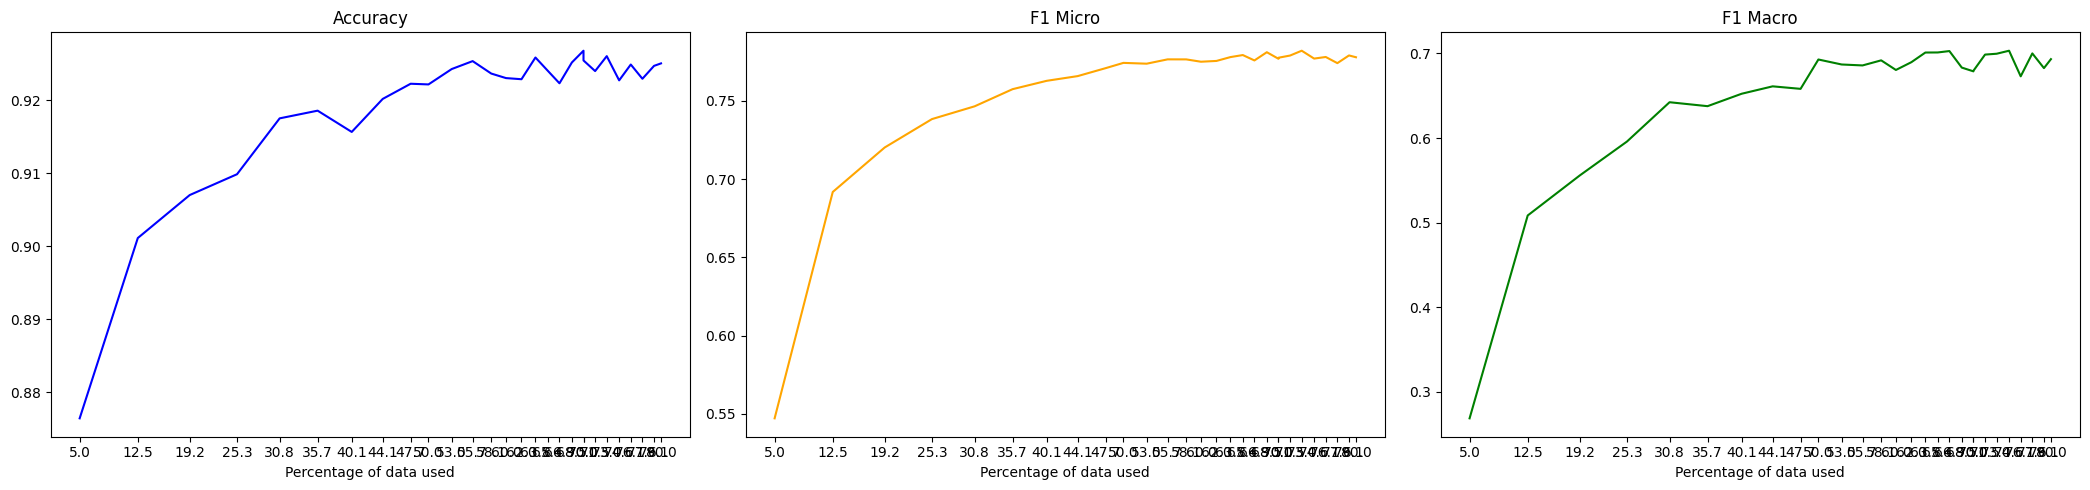

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5815, Accuracy: 0.8273, F1 Micro: 0.3943, F1 Macro: 0.1042
Epoch 2/10, Train Loss: 0.4544, Accuracy: 0.8345, F1 Micro: 0.2205, F1 Macro: 0.0565
Epoch 3/10, Train Loss: 0.4043, Accuracy: 0.8322, F1 Micro: 0.0793, F1 Macro: 0.0316
Epoch 4/10, Train Loss: 0.3672, Accuracy: 0.8369, F1 Micro: 0.1519, F1 Macro: 0.0501
Epoch 5/10, Train Loss: 0.3623, Accuracy: 0.8455, F1 Micro: 0.2415, F1 Macro: 0.0848
Epoch 6/10, Train Loss: 0.3367, Accuracy: 0.8517, F1 Micro: 0.3286, F1 Macro: 0.1153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3235, Accuracy: 0.8681, F1 Micro: 0.4938, F1 Macro: 0.2278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3035, Accuracy: 0.8719, F1 Micro: 0.5345, F1 Macro: 0.2502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2634, Accuracy: 0.8738, F1 Micro: 0.5938, F1 Macro: 0.278
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2673, Accuracy: 0.8758, F1 Micro: 0.5957, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5356, Accuracy: 0.8161, F1 Micro: 0.301, F1 Macro: 0.0688
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4308, Accuracy: 0.836, F1 Micro: 0.4038, F1 Macro: 0.1096
Epoch 3/10, Train Loss: 0.4055, Accuracy: 0.8476, F1 Micro: 0.4023, F1 Macro: 0.1266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3818, Accuracy: 0.8629, F1 Micro: 0.5092, F1 Macro: 0.2318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3506, Accuracy: 0.8838, F1 Micro: 0.6138, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3134, Accuracy: 0.8898, F1 Micro: 0.6438, F1 Macro: 0.3793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2754, Accuracy: 0.8919, F1 Micro: 0.6582, F1 Macro: 0.4064
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2396, Accuracy: 0.8957, F1 Micro: 0.6814, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2126, Accuracy: 0.8977, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5045, Accuracy: 0.8217, F1 Micro: 0.3932, F1 Macro: 0.1039
Epoch 2/10, Train Loss: 0.4163, Accuracy: 0.8404, F1 Micro: 0.3729, F1 Macro: 0.1092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3932, Accuracy: 0.8603, F1 Micro: 0.514, F1 Macro: 0.2379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3631, Accuracy: 0.8866, F1 Micro: 0.6426, F1 Macro: 0.3701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3123, Accuracy: 0.8977, F1 Micro: 0.6738, F1 Macro: 0.4445
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2696, Accuracy: 0.8979, F1 Micro: 0.7014, F1 Macro: 0.4814
Epoch 7/10, Train Loss: 0.2403, Accuracy: 0.9028, F1 Micro: 0.6976, F1 Macro: 0.4772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2053, Accuracy: 0.9071, F1 Micro: 0.7081, F1 Macro: 0.5215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1714, Accuracy: 0.906, F1 Micro: 0.7113, F1 Macro: 0.5207
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4875, Accuracy: 0.8237, F1 Micro: 0.3949, F1 Macro: 0.105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4128, Accuracy: 0.8551, F1 Micro: 0.477, F1 Macro: 0.1911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3744, Accuracy: 0.8846, F1 Micro: 0.6041, F1 Macro: 0.3591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3327, Accuracy: 0.9006, F1 Micro: 0.6895, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2822, Accuracy: 0.908, F1 Micro: 0.7147, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2396, Accuracy: 0.9068, F1 Micro: 0.726, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2069, Accuracy: 0.9107, F1 Micro: 0.7312, F1 Macro: 0.5427
Epoch 8/10, Train Loss: 0.1695, Accuracy: 0.911, F1 Micro: 0.7309, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1475, Accuracy: 0.9121, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4801, Accuracy: 0.8247, F1 Micro: 0.3946, F1 Macro: 0.1134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4023, Accuracy: 0.8621, F1 Micro: 0.5618, F1 Macro: 0.2826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3623, Accuracy: 0.8952, F1 Micro: 0.6495, F1 Macro: 0.4483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3191, Accuracy: 0.9051, F1 Micro: 0.7124, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2728, Accuracy: 0.9078, F1 Micro: 0.7255, F1 Macro: 0.5232
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2313, Accuracy: 0.9118, F1 Micro: 0.7334, F1 Macro: 0.5596
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1955, Accuracy: 0.9129, F1 Micro: 0.738, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1575, Accuracy: 0.9129, F1 Micro: 0.7464, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4715, Accuracy: 0.8369, F1 Micro: 0.4103, F1 Macro: 0.1173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3946, Accuracy: 0.8769, F1 Micro: 0.5743, F1 Macro: 0.2829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3488, Accuracy: 0.8986, F1 Micro: 0.6876, F1 Macro: 0.4656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3049, Accuracy: 0.9071, F1 Micro: 0.7132, F1 Macro: 0.5205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2582, Accuracy: 0.9125, F1 Micro: 0.7291, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2195, Accuracy: 0.9171, F1 Micro: 0.7423, F1 Macro: 0.5803
Epoch 7/10, Train Loss: 0.1813, Accuracy: 0.9167, F1 Micro: 0.7413, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1535, Accuracy: 0.9156, F1 Micro: 0.7435, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1253, Accuracy: 0.9135, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4664, Accuracy: 0.8444, F1 Micro: 0.3985, F1 Macro: 0.1325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.383, Accuracy: 0.8903, F1 Micro: 0.6429, F1 Macro: 0.384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3304, Accuracy: 0.9031, F1 Micro: 0.6767, F1 Macro: 0.4598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2827, Accuracy: 0.91, F1 Micro: 0.7425, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2405, Accuracy: 0.9073, F1 Micro: 0.7438, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2084, Accuracy: 0.9171, F1 Micro: 0.7573, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1683, Accuracy: 0.9201, F1 Micro: 0.7619, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1439, Accuracy: 0.9205, F1 Micro: 0.7633, F1 Macro: 0.6321
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.12

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.459, Accuracy: 0.8506, F1 Micro: 0.4642, F1 Macro: 0.1892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3762, Accuracy: 0.8942, F1 Micro: 0.6687, F1 Macro: 0.4162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3162, Accuracy: 0.9055, F1 Micro: 0.7233, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2717, Accuracy: 0.9158, F1 Micro: 0.7328, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2304, Accuracy: 0.9173, F1 Micro: 0.7524, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1923, Accuracy: 0.9191, F1 Micro: 0.7585, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1613, Accuracy: 0.9181, F1 Micro: 0.7656, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1397, Accuracy: 0.9225, F1 Micro: 0.772, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.1174, Accuracy: 0.9194, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.8528, F1 Micro: 0.5003, F1 Macro: 0.2206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3619, Accuracy: 0.9005, F1 Micro: 0.6773, F1 Macro: 0.4826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.304, Accuracy: 0.9141, F1 Micro: 0.7286, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2599, Accuracy: 0.9194, F1 Micro: 0.7607, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2191, Accuracy: 0.9177, F1 Micro: 0.7667, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1848, Accuracy: 0.9225, F1 Micro: 0.7715, F1 Macro: 0.6239
Epoch 7/10, Train Loss: 0.1514, Accuracy: 0.9251, F1 Micro: 0.77, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9233, F1 Micro: 0.7686, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1077, Accuracy: 0.9223, F1 Micro: 0.7768, F1 Macro: 0.6841
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.857, F1 Micro: 0.5232, F1 Macro: 0.248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3568, Accuracy: 0.8984, F1 Micro: 0.697, F1 Macro: 0.488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3012, Accuracy: 0.9125, F1 Micro: 0.7154, F1 Macro: 0.5546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2529, Accuracy: 0.9186, F1 Micro: 0.7606, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2116, Accuracy: 0.9231, F1 Micro: 0.7619, F1 Macro: 0.6081
Epoch 6/10, Train Loss: 0.1761, Accuracy: 0.9227, F1 Micro: 0.7613, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1497, Accuracy: 0.9251, F1 Micro: 0.771, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.126, Accuracy: 0.9249, F1 Micro: 0.7772, F1 Macro: 0.6741
Epoch 9/10, Train Loss: 0.1082, Accuracy: 0.9252, F1 Micro: 0.7707, F1 Macro: 0.6716
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8612, F1 Micro: 0.5348, F1 Macro: 0.2636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3459, Accuracy: 0.9025, F1 Micro: 0.7028, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2875, Accuracy: 0.9125, F1 Micro: 0.7177, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2425, Accuracy: 0.9144, F1 Micro: 0.7549, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2044, Accuracy: 0.9211, F1 Micro: 0.7709, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.1717, Accuracy: 0.9227, F1 Micro: 0.7695, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1436, Accuracy: 0.9218, F1 Micro: 0.7756, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1238, Accuracy: 0.9256, F1 Micro: 0.7797, F1 Macro: 0.6797
Epoch 9/10, Train Loss: 0.1026, Accuracy: 0.9232, F1 Micro: 0.775, F1 Macro: 0.682
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8689, F1 Micro: 0.6024, F1 Macro: 0.3066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3324, Accuracy: 0.9054, F1 Micro: 0.71, F1 Macro: 0.5242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2747, Accuracy: 0.914, F1 Micro: 0.7424, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2315, Accuracy: 0.9204, F1 Micro: 0.7601, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.193, Accuracy: 0.9216, F1 Micro: 0.7674, F1 Macro: 0.6343
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9245, F1 Micro: 0.7706, F1 Macro: 0.6646
Epoch 7/10, Train Loss: 0.1394, Accuracy: 0.922, F1 Micro: 0.7537, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1206, Accuracy: 0.9244, F1 Micro: 0.7819, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0988, Accuracy: 0.9252, F1 Micro: 0.7786, F1 Macro: 0.6929
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.8739, F1 Micro: 0.6, F1 Macro: 0.3129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3276, Accuracy: 0.9049, F1 Micro: 0.717, F1 Macro: 0.5465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2696, Accuracy: 0.9164, F1 Micro: 0.7363, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2266, Accuracy: 0.9198, F1 Micro: 0.7657, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1959, Accuracy: 0.9231, F1 Micro: 0.7737, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1624, Accuracy: 0.9218, F1 Micro: 0.776, F1 Macro: 0.6713
Epoch 7/10, Train Loss: 0.1385, Accuracy: 0.9246, F1 Micro: 0.7741, F1 Macro: 0.6699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1206, Accuracy: 0.9253, F1 Micro: 0.787, F1 Macro: 0.6868
Epoch 9/10, Train Loss: 0.1004, Accuracy: 0.9252, F1 Micro: 0.7807, F1 Macro: 0.6926
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4305, Accuracy: 0.8797, F1 Micro: 0.601, F1 Macro: 0.3198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3184, Accuracy: 0.9051, F1 Micro: 0.7159, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2656, Accuracy: 0.9151, F1 Micro: 0.75, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2228, Accuracy: 0.9192, F1 Micro: 0.7599, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1872, Accuracy: 0.9243, F1 Micro: 0.7682, F1 Macro: 0.6253
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1545, Accuracy: 0.9259, F1 Micro: 0.7827, F1 Macro: 0.6741
Epoch 7/10, Train Loss: 0.134, Accuracy: 0.9222, F1 Micro: 0.7752, F1 Macro: 0.6694
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.9252, F1 Micro: 0.7755, F1 Macro: 0.6811
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9254, F1 Micro: 0.7808, F1 Macro: 0.6828
Epoch 10/10, Train Loss: 0.0865, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4212, Accuracy: 0.8817, F1 Micro: 0.5898, F1 Macro: 0.3005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3124, Accuracy: 0.9058, F1 Micro: 0.7176, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.9136, F1 Micro: 0.7305, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2145, Accuracy: 0.9214, F1 Micro: 0.7628, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9253, F1 Micro: 0.7745, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9237, F1 Micro: 0.7764, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9252, F1 Micro: 0.7796, F1 Macro: 0.6743
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.926, F1 Micro: 0.7762, F1 Macro: 0.6799
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9234, F1 Micro: 0.7754, F1 Macro: 0.6944
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.8853, F1 Micro: 0.6256, F1 Macro: 0.3483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.9037, F1 Micro: 0.7191, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2537, Accuracy: 0.916, F1 Micro: 0.7467, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2093, Accuracy: 0.9213, F1 Micro: 0.7646, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9242, F1 Micro: 0.7711, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9255, F1 Micro: 0.7774, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9253, F1 Micro: 0.7811, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9238, F1 Micro: 0.7691, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9241, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4168, Accuracy: 0.886, F1 Micro: 0.6011, F1 Macro: 0.3109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2987, Accuracy: 0.9068, F1 Micro: 0.7135, F1 Macro: 0.5354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.9131, F1 Micro: 0.7516, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.9237, F1 Micro: 0.7678, F1 Macro: 0.616
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9159, F1 Micro: 0.7674, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.925, F1 Micro: 0.7774, F1 Macro: 0.664
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9252, F1 Micro: 0.7693, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9246, F1 Micro: 0.7785, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9243, F1 Micro: 0.7785, F1 Macro: 0.6834
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.886, F1 Micro: 0.6089, F1 Macro: 0.318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.908, F1 Micro: 0.7034, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9125, F1 Micro: 0.7449, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9219, F1 Micro: 0.7659, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9191, F1 Micro: 0.7732, F1 Macro: 0.6583
Epoch 6/10, Train Loss: 0.1461, Accuracy: 0.92, F1 Micro: 0.768, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9256, F1 Micro: 0.7773, F1 Macro: 0.6685
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9248, F1 Micro: 0.7754, F1 Macro: 0.6831
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9235, F1 Micro: 0.7653, F1 Macro: 0.6729
Epoch 10/10, Train Loss: 0.0814, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.888, F1 Micro: 0.6228, F1 Macro: 0.3295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.9049, F1 Micro: 0.7114, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9123, F1 Micro: 0.7495, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9238, F1 Micro: 0.7658, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9258, F1 Micro: 0.777, F1 Macro: 0.6567
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9226, F1 Micro: 0.7721, F1 Macro: 0.6686
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9269, F1 Micro: 0.7762, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9254, F1 Micro: 0.7835, F1 Macro: 0.6923
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9246, F1 Micro: 0.7689, F1 Macro: 0.6719
Epoch 10/10, Train Loss: 0.0746, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8868, F1 Micro: 0.605, F1 Macro: 0.313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9073, F1 Micro: 0.7109, F1 Macro: 0.5023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.915, F1 Micro: 0.7478, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9213, F1 Micro: 0.7679, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9202, F1 Micro: 0.7699, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.924, F1 Micro: 0.7721, F1 Macro: 0.6578
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9239, F1 Micro: 0.7699, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9258, F1 Micro: 0.7776, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9257, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3996, Accuracy: 0.8891, F1 Micro: 0.6171, F1 Macro: 0.3325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2859, Accuracy: 0.9084, F1 Micro: 0.7141, F1 Macro: 0.5308
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.9168, F1 Micro: 0.7511, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.919, F1 Micro: 0.7619, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9226, F1 Micro: 0.7674, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.9251, F1 Micro: 0.7737, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9261, F1 Micro: 0.7785, F1 Macro: 0.6798
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9193, F1 Micro: 0.7707, F1 Macro: 0.6789
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9248, F1 Micro: 0.7777, F1 Macro: 0.6863
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8857, F1 Micro: 0.5816, F1 Macro: 0.2978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9066, F1 Micro: 0.7211, F1 Macro: 0.5163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9126, F1 Micro: 0.7476, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9214, F1 Micro: 0.7709, F1 Macro: 0.6143
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9164, F1 Micro: 0.7663, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9209, F1 Micro: 0.775, F1 Macro: 0.669
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9254, F1 Micro: 0.7742, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9236, F1 Micro: 0.7785, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9239, F1 Micro: 0.7794, F1 Macro: 0.6932
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8885, F1 Micro: 0.6392, F1 Macro: 0.3365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.91, F1 Micro: 0.7162, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.9143, F1 Micro: 0.7542, F1 Macro: 0.5924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9193, F1 Micro: 0.7595, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9244, F1 Micro: 0.7735, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9239, F1 Micro: 0.7674, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9221, F1 Micro: 0.7771, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9256, F1 Micro: 0.7803, F1 Macro: 0.6831
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9241, F1 Micro: 0.7761, F1 Macro: 0.6875
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8911, F1 Micro: 0.6242, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.9039, F1 Micro: 0.7197, F1 Macro: 0.5449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9089, F1 Micro: 0.7464, F1 Macro: 0.5887
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.918, F1 Micro: 0.7316, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9209, F1 Micro: 0.7734, F1 Macro: 0.6328
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9194, F1 Micro: 0.7704, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9249, F1 Micro: 0.7768, F1 Macro: 0.6715
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9239, F1 Micro: 0.775, F1 Macro: 0.6791
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9253, F1 Micro: 0.7761, F1 Macro: 0.6894
Epoch 10/10, Train Loss: 0.0663, Accuracy: 0.9173, F1 Micro: 0.7684, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.8873, F1 Micro: 0.5918, F1 Macro: 0.3016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9047, F1 Micro: 0.6714, F1 Macro: 0.4525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9162, F1 Micro: 0.7467, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.92, F1 Micro: 0.7695, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9237, F1 Micro: 0.7753, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9241, F1 Micro: 0.7754, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9267, F1 Micro: 0.7794, F1 Macro: 0.6759
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9238, F1 Micro: 0.7774, F1 Macro: 0.686
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9252, F1 Micro: 0.7768, F1 Macro: 0.6798
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3746, Accuracy: 0.8912, F1 Micro: 0.6332, F1 Macro: 0.3391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9097, F1 Micro: 0.7246, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.915, F1 Micro: 0.7529, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9195, F1 Micro: 0.7618, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9196, F1 Micro: 0.7676, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9231, F1 Micro: 0.7729, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9231, F1 Micro: 0.7758, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9259, F1 Micro: 0.7798, F1 Macro: 0.6807
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9222, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8848, F1 Micro: 0.5585, F1 Macro: 0.2808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9076, F1 Micro: 0.7111, F1 Macro: 0.5036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.916, F1 Micro: 0.7465, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9219, F1 Micro: 0.7628, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9223, F1 Micro: 0.7713, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9222, F1 Micro: 0.7737, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9231, F1 Micro: 0.776, F1 Macro: 0.6597
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9241, F1 Micro: 0.7738, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9231, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3681, Accuracy: 0.8913, F1 Micro: 0.6476, F1 Macro: 0.3413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.9088, F1 Micro: 0.7025, F1 Macro: 0.5175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.917, F1 Micro: 0.7513, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9119, F1 Micro: 0.7602, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9257, F1 Micro: 0.7758, F1 Macro: 0.6388
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9218, F1 Micro: 0.7753, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9245, F1 Micro: 0.7794, F1 Macro: 0.6832
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9187, F1 Micro: 0.774, F1 Macro: 0.6977
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9253, F1 Micro: 0.7776, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 1

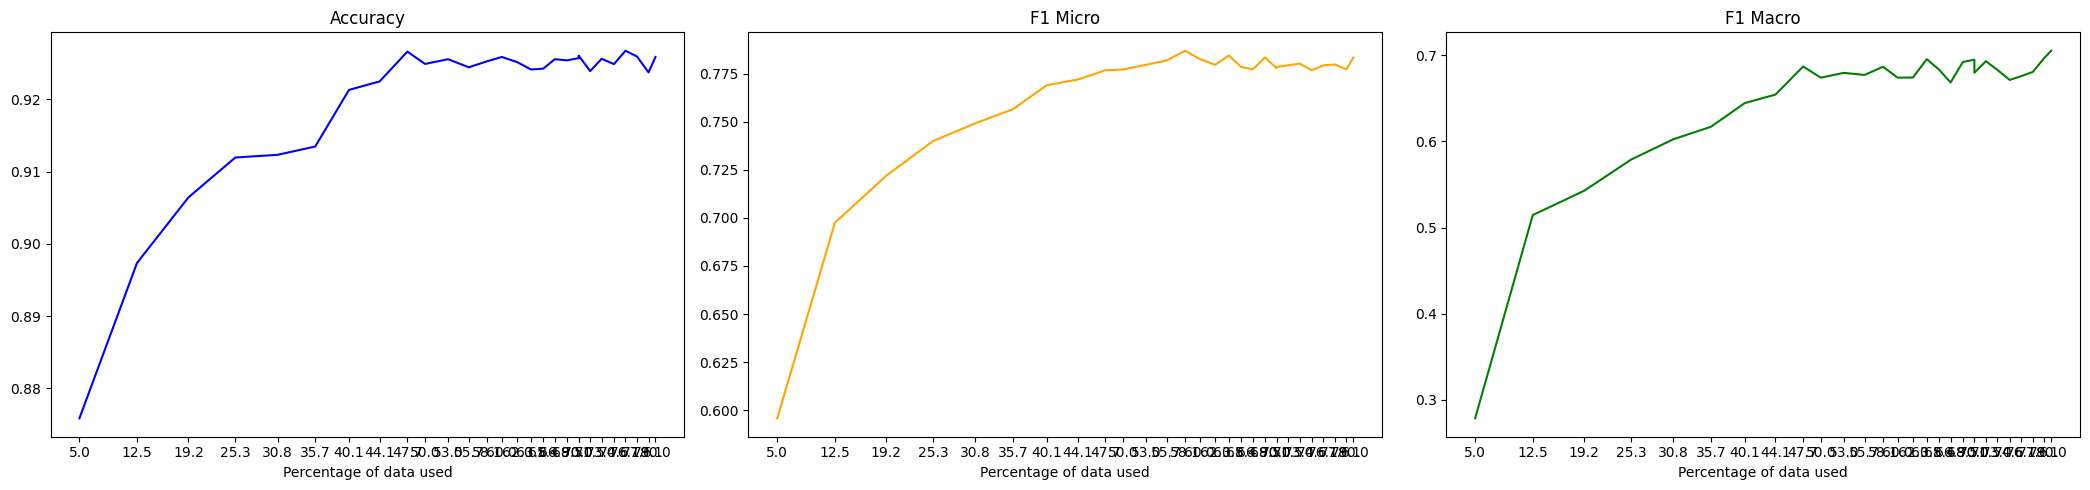

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.598, Accuracy: 0.831, F1 Micro: 0.1955, F1 Macro: 0.0519
Epoch 2/10, Train Loss: 0.4533, Accuracy: 0.8295, F1 Micro: 0.0546, F1 Macro: 0.0197
Epoch 3/10, Train Loss: 0.4229, Accuracy: 0.835, F1 Micro: 0.1221, F1 Macro: 0.0472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3844, Accuracy: 0.8464, F1 Micro: 0.2682, F1 Macro: 0.0907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3786, Accuracy: 0.848, F1 Micro: 0.2905, F1 Macro: 0.0962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.353, Accuracy: 0.8561, F1 Micro: 0.4159, F1 Macro: 0.1412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3465, Accuracy: 0.8651, F1 Micro: 0.4363, F1 Macro: 0.1893
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3138, Accuracy: 0.8708, F1 Micro: 0.5781, F1 Macro: 0.2666
Epoch 9/10, Train Loss: 0.3048, Accuracy: 0.8742, F1 Micro: 0.5702, F1 Macro: 0.2653
Epoch 10/10, Train Loss: 0.2677, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5376, Accuracy: 0.8256, F1 Micro: 0.293, F1 Macro: 0.0645
Epoch 2/10, Train Loss: 0.4321, Accuracy: 0.8425, F1 Micro: 0.2883, F1 Macro: 0.0904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4116, Accuracy: 0.8481, F1 Micro: 0.3847, F1 Macro: 0.1126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3832, Accuracy: 0.8687, F1 Micro: 0.5326, F1 Macro: 0.2474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3481, Accuracy: 0.8881, F1 Micro: 0.621, F1 Macro: 0.346
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3025, Accuracy: 0.8919, F1 Micro: 0.6663, F1 Macro: 0.4304
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2747, Accuracy: 0.8966, F1 Micro: 0.6691, F1 Macro: 0.4319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2478, Accuracy: 0.8954, F1 Micro: 0.6768, F1 Macro: 0.4654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2086, Accuracy: 0.8988, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5078, Accuracy: 0.8246, F1 Micro: 0.3903, F1 Macro: 0.105
Epoch 2/10, Train Loss: 0.42, Accuracy: 0.8394, F1 Micro: 0.3896, F1 Macro: 0.1114
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3928, Accuracy: 0.8625, F1 Micro: 0.4566, F1 Macro: 0.1801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3595, Accuracy: 0.893, F1 Micro: 0.6456, F1 Macro: 0.3838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3182, Accuracy: 0.8918, F1 Micro: 0.6978, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2742, Accuracy: 0.9025, F1 Micro: 0.7053, F1 Macro: 0.5193
Epoch 7/10, Train Loss: 0.2447, Accuracy: 0.9054, F1 Micro: 0.6935, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2101, Accuracy: 0.903, F1 Micro: 0.7261, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1742, Accuracy: 0.9089, F1 Micro: 0.7312, F1 Macro: 0.5583
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4877, Accuracy: 0.8277, F1 Micro: 0.3987, F1 Macro: 0.1071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4129, Accuracy: 0.8462, F1 Micro: 0.4382, F1 Macro: 0.1573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.367, Accuracy: 0.8897, F1 Micro: 0.6674, F1 Macro: 0.4225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3245, Accuracy: 0.904, F1 Micro: 0.6888, F1 Macro: 0.4686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2766, Accuracy: 0.9081, F1 Micro: 0.7288, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2388, Accuracy: 0.9102, F1 Micro: 0.7342, F1 Macro: 0.5432
Epoch 7/10, Train Loss: 0.2001, Accuracy: 0.9088, F1 Micro: 0.7292, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1704, Accuracy: 0.9126, F1 Micro: 0.7346, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1495, Accuracy: 0.9121, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4819, Accuracy: 0.8291, F1 Micro: 0.3983, F1 Macro: 0.1085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.402, Accuracy: 0.8715, F1 Micro: 0.5745, F1 Macro: 0.3034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3593, Accuracy: 0.8957, F1 Micro: 0.6822, F1 Macro: 0.44
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.307, Accuracy: 0.9072, F1 Micro: 0.7117, F1 Macro: 0.5058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2623, Accuracy: 0.9103, F1 Micro: 0.7309, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2226, Accuracy: 0.9137, F1 Micro: 0.7424, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1845, Accuracy: 0.9129, F1 Micro: 0.7463, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1588, Accuracy: 0.9138, F1 Micro: 0.7474, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.13

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.8291, F1 Micro: 0.4043, F1 Macro: 0.1156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3943, Accuracy: 0.8843, F1 Micro: 0.6041, F1 Macro: 0.3356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3418, Accuracy: 0.9048, F1 Micro: 0.6918, F1 Macro: 0.4829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2955, Accuracy: 0.9102, F1 Micro: 0.732, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2507, Accuracy: 0.9145, F1 Micro: 0.7473, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2066, Accuracy: 0.915, F1 Micro: 0.7577, F1 Macro: 0.6017
Epoch 7/10, Train Loss: 0.1751, Accuracy: 0.9155, F1 Micro: 0.7543, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1446, Accuracy: 0.9173, F1 Micro: 0.7579, F1 Macro: 0.6241
Epoch 9/10, Train Loss: 0.1281, Accuracy: 0.9166, F1 Micro: 0.7542, F1 Macro: 0.6258
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.47, Accuracy: 0.8407, F1 Micro: 0.4005, F1 Macro: 0.1136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.381, Accuracy: 0.891, F1 Micro: 0.6232, F1 Macro: 0.3467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3284, Accuracy: 0.9075, F1 Micro: 0.7151, F1 Macro: 0.5435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2809, Accuracy: 0.9128, F1 Micro: 0.7486, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.236, Accuracy: 0.9152, F1 Micro: 0.7542, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2025, Accuracy: 0.9194, F1 Micro: 0.7584, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.921, F1 Micro: 0.7619, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1454, Accuracy: 0.9218, F1 Micro: 0.7646, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1216, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4628, Accuracy: 0.8457, F1 Micro: 0.4251, F1 Macro: 0.148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3743, Accuracy: 0.8974, F1 Micro: 0.6812, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3103, Accuracy: 0.9104, F1 Micro: 0.7131, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2672, Accuracy: 0.9191, F1 Micro: 0.748, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2253, Accuracy: 0.9212, F1 Micro: 0.7615, F1 Macro: 0.6098
Epoch 6/10, Train Loss: 0.1895, Accuracy: 0.9213, F1 Micro: 0.753, F1 Macro: 0.6307
Epoch 7/10, Train Loss: 0.1579, Accuracy: 0.9205, F1 Micro: 0.7594, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1329, Accuracy: 0.9209, F1 Micro: 0.7688, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1146, Accuracy: 0.9226, F1 Micro: 0.7716, F1 Macro: 0.6675
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4578, Accuracy: 0.8577, F1 Micro: 0.5098, F1 Macro: 0.2164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3601, Accuracy: 0.9018, F1 Micro: 0.6931, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2969, Accuracy: 0.9116, F1 Micro: 0.7357, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2534, Accuracy: 0.9134, F1 Micro: 0.7506, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2179, Accuracy: 0.9208, F1 Micro: 0.7567, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1768, Accuracy: 0.9218, F1 Micro: 0.7663, F1 Macro: 0.6454
Epoch 7/10, Train Loss: 0.1498, Accuracy: 0.9229, F1 Micro: 0.7662, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1304, Accuracy: 0.9229, F1 Micro: 0.7696, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1106, Accuracy: 0.9238, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.8626, F1 Micro: 0.5286, F1 Macro: 0.2564
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3491, Accuracy: 0.9029, F1 Micro: 0.6852, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2902, Accuracy: 0.9157, F1 Micro: 0.7399, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2482, Accuracy: 0.921, F1 Micro: 0.7549, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2148, Accuracy: 0.9217, F1 Micro: 0.7634, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1737, Accuracy: 0.9203, F1 Micro: 0.7745, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1475, Accuracy: 0.9225, F1 Micro: 0.7754, F1 Macro: 0.6749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1256, Accuracy: 0.9225, F1 Micro: 0.7754, F1 Macro: 0.6815
Epoch 9/10, Train Loss: 0.1103, Accuracy: 0.9242, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8743, F1 Micro: 0.5299, F1 Macro: 0.248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3441, Accuracy: 0.9019, F1 Micro: 0.7035, F1 Macro: 0.5072
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.9147, F1 Micro: 0.7297, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2419, Accuracy: 0.9203, F1 Micro: 0.7564, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2011, Accuracy: 0.9214, F1 Micro: 0.7682, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1702, Accuracy: 0.9218, F1 Micro: 0.7688, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.145, Accuracy: 0.9226, F1 Micro: 0.7791, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1231, Accuracy: 0.9247, F1 Micro: 0.7828, F1 Macro: 0.6999
Epoch 9/10, Train Loss: 0.1089, Accuracy: 0.9255, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8798, F1 Micro: 0.5739, F1 Macro: 0.2906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3314, Accuracy: 0.9065, F1 Micro: 0.6967, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2687, Accuracy: 0.9161, F1 Micro: 0.7415, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.9214, F1 Micro: 0.7528, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1912, Accuracy: 0.9239, F1 Micro: 0.7773, F1 Macro: 0.6573
Epoch 6/10, Train Loss: 0.162, Accuracy: 0.9223, F1 Micro: 0.7759, F1 Macro: 0.6704
Epoch 7/10, Train Loss: 0.1432, Accuracy: 0.9244, F1 Micro: 0.7739, F1 Macro: 0.6735
Epoch 8/10, Train Loss: 0.1152, Accuracy: 0.9247, F1 Micro: 0.7749, F1 Macro: 0.6775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0991, Accuracy: 0.9218, F1 Micro: 0.7783, F1 Macro: 0.6907
Epoch 10/10, Train Loss: 0.0907, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.8815, F1 Micro: 0.6141, F1 Macro: 0.3327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3222, Accuracy: 0.8999, F1 Micro: 0.7161, F1 Macro: 0.5511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2652, Accuracy: 0.9144, F1 Micro: 0.7353, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.9207, F1 Micro: 0.7551, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1922, Accuracy: 0.9227, F1 Micro: 0.7668, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1642, Accuracy: 0.9232, F1 Micro: 0.7695, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9241, F1 Micro: 0.7791, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.118, Accuracy: 0.9253, F1 Micro: 0.7798, F1 Macro: 0.685
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.9227, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.8842, F1 Micro: 0.6312, F1 Macro: 0.3454
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3176, Accuracy: 0.9067, F1 Micro: 0.7008, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2599, Accuracy: 0.9171, F1 Micro: 0.7455, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2159, Accuracy: 0.9226, F1 Micro: 0.7633, F1 Macro: 0.6059
Epoch 5/10, Train Loss: 0.1838, Accuracy: 0.9236, F1 Micro: 0.7595, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.161, Accuracy: 0.9224, F1 Micro: 0.777, F1 Macro: 0.6624
Epoch 7/10, Train Loss: 0.1295, Accuracy: 0.9236, F1 Micro: 0.7732, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9255, F1 Micro: 0.7791, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9253, F1 Micro: 0.7761, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.8845, F1 Micro: 0.6348, F1 Macro: 0.3344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3047, Accuracy: 0.9082, F1 Micro: 0.7169, F1 Macro: 0.5151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2474, Accuracy: 0.9135, F1 Micro: 0.7533, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9202, F1 Micro: 0.7643, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9243, F1 Micro: 0.7679, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9195, F1 Micro: 0.7718, F1 Macro: 0.67
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9223, F1 Micro: 0.7688, F1 Macro: 0.6449
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9258, F1 Micro: 0.7767, F1 Macro: 0.6923
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.9255, F1 Micro: 0.7761, F1 Macro: 0.6974
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.417, Accuracy: 0.886, F1 Micro: 0.6491, F1 Macro: 0.4057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.9078, F1 Micro: 0.7217, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2498, Accuracy: 0.9155, F1 Micro: 0.7504, F1 Macro: 0.583
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9213, F1 Micro: 0.7487, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9222, F1 Micro: 0.77, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9225, F1 Micro: 0.7732, F1 Macro: 0.6586
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9247, F1 Micro: 0.7688, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1042, Accuracy: 0.9227, F1 Micro: 0.7812, F1 Macro: 0.6905
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9257, F1 Micro: 0.7765, F1 Macro: 0.6898
Epoch 10/10, Train Loss: 0.0749, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.8874, F1 Micro: 0.6401, F1 Macro: 0.3752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.9022, F1 Micro: 0.7221, F1 Macro: 0.5228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2423, Accuracy: 0.9143, F1 Micro: 0.7321, F1 Macro: 0.5397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2027, Accuracy: 0.9214, F1 Micro: 0.7653, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.172, Accuracy: 0.9224, F1 Micro: 0.7756, F1 Macro: 0.6542
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9224, F1 Micro: 0.7741, F1 Macro: 0.6669
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9231, F1 Micro: 0.7712, F1 Macro: 0.6804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9242, F1 Micro: 0.7817, F1 Macro: 0.6935
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.923, F1 Micro: 0.7789, F1 Macro: 0.7028
Epoch 10/10, Train Loss: 0.0748, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4072, Accuracy: 0.885, F1 Micro: 0.5798, F1 Macro: 0.3326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.9076, F1 Micro: 0.7002, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.9157, F1 Micro: 0.7488, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2006, Accuracy: 0.9222, F1 Micro: 0.7688, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9231, F1 Micro: 0.7737, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9203, F1 Micro: 0.7743, F1 Macro: 0.6712
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.922, F1 Micro: 0.7706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.9237, F1 Micro: 0.7784, F1 Macro: 0.6821
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9253, F1 Micro: 0.7783, F1 Macro: 0.685
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8887, F1 Micro: 0.6542, F1 Macro: 0.3729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2823, Accuracy: 0.9079, F1 Micro: 0.7093, F1 Macro: 0.5052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.9177, F1 Micro: 0.7549, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1933, Accuracy: 0.9215, F1 Micro: 0.7658, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9211, F1 Micro: 0.7709, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9231, F1 Micro: 0.783, F1 Macro: 0.685
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9205, F1 Micro: 0.7723, F1 Macro: 0.6659
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9253, F1 Micro: 0.7769, F1 Macro: 0.6902
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9252, F1 Micro: 0.7741, F1 Macro: 0.689
Epoch 10/10, Train Loss: 0.0755, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3989, Accuracy: 0.8844, F1 Micro: 0.65, F1 Macro: 0.3943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9064, F1 Micro: 0.7097, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9166, F1 Micro: 0.7565, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.9191, F1 Micro: 0.7575, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9253, F1 Micro: 0.7702, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9247, F1 Micro: 0.7772, F1 Macro: 0.6732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1166, Accuracy: 0.9246, F1 Micro: 0.7799, F1 Macro: 0.6875
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.922, F1 Micro: 0.7766, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9217, F1 Micro: 0.7772, F1 Macro: 0.6937
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3969, Accuracy: 0.8879, F1 Micro: 0.6036, F1 Macro: 0.3294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.9101, F1 Micro: 0.704, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.9182, F1 Micro: 0.7481, F1 Macro: 0.5872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9181, F1 Micro: 0.7641, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9247, F1 Micro: 0.7753, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9247, F1 Micro: 0.7756, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9239, F1 Micro: 0.7716, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9258, F1 Micro: 0.7804, F1 Macro: 0.6894
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9224, F1 Micro: 0.7793, F1 Macro: 0.6919
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8886, F1 Micro: 0.649, F1 Macro: 0.3592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.9076, F1 Micro: 0.7299, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9168, F1 Micro: 0.7556, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9227, F1 Micro: 0.7712, F1 Macro: 0.6231
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9251, F1 Micro: 0.7659, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9218, F1 Micro: 0.775, F1 Macro: 0.6652
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9241, F1 Micro: 0.7729, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9261, F1 Micro: 0.7785, F1 Macro: 0.6879
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9224, F1 Micro: 0.7771, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.8876, F1 Micro: 0.6259, F1 Macro: 0.3363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9091, F1 Micro: 0.7262, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9175, F1 Micro: 0.7442, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9213, F1 Micro: 0.7628, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9195, F1 Micro: 0.768, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.924, F1 Micro: 0.7775, F1 Macro: 0.6778
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9174, F1 Micro: 0.7693, F1 Macro: 0.6719
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9226, F1 Micro: 0.7697, F1 Macro: 0.6892
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9213, F1 Micro: 0.7717, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.8881, F1 Micro: 0.6042, F1 Macro: 0.3276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9098, F1 Micro: 0.715, F1 Macro: 0.5296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9163, F1 Micro: 0.7544, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9228, F1 Micro: 0.7664, F1 Macro: 0.6144
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9222, F1 Micro: 0.764, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9235, F1 Micro: 0.7681, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9237, F1 Micro: 0.7772, F1 Macro: 0.6797
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.924, F1 Micro: 0.7729, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9228, F1 Micro: 0.7794, F1 Macro: 0.6932
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.8896, F1 Micro: 0.6309, F1 Macro: 0.329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.9086, F1 Micro: 0.6921, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9189, F1 Micro: 0.757, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9204, F1 Micro: 0.7636, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9174, F1 Micro: 0.7691, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9255, F1 Micro: 0.7781, F1 Macro: 0.6779
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9209, F1 Micro: 0.7746, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9243, F1 Micro: 0.7788, F1 Macro: 0.6943
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9231, F1 Micro: 0.777, F1 Macro: 0.6929
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8894, F1 Micro: 0.6214, F1 Macro: 0.3186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9087, F1 Micro: 0.708, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9162, F1 Micro: 0.7533, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9224, F1 Micro: 0.7664, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9225, F1 Micro: 0.7704, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9235, F1 Micro: 0.7716, F1 Macro: 0.6766
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9214, F1 Micro: 0.7649, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9241, F1 Micro: 0.7764, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9253, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.8903, F1 Micro: 0.6285, F1 Macro: 0.3297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9068, F1 Micro: 0.7173, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9181, F1 Micro: 0.7421, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9221, F1 Micro: 0.7657, F1 Macro: 0.6088
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9235, F1 Micro: 0.7657, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9228, F1 Micro: 0.7737, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9253, F1 Micro: 0.7803, F1 Macro: 0.6802
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9246, F1 Micro: 0.7756, F1 Macro: 0.6683
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9257, F1 Micro: 0.778, F1 Macro: 0.6915
Epoch 10/10, Train Loss: 0.0622, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3675, Accuracy: 0.8899, F1 Micro: 0.6451, F1 Macro: 0.3684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9098, F1 Micro: 0.7254, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9191, F1 Micro: 0.751, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9217, F1 Micro: 0.7644, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.919, F1 Micro: 0.771, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.92, F1 Micro: 0.7742, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.922, F1 Micro: 0.777, F1 Macro: 0.6853
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9241, F1 Micro: 0.7754, F1 Macro: 0.6779
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9237, F1 Micro: 0.7731, F1 Macro: 0.6831
Epoch 10/10,

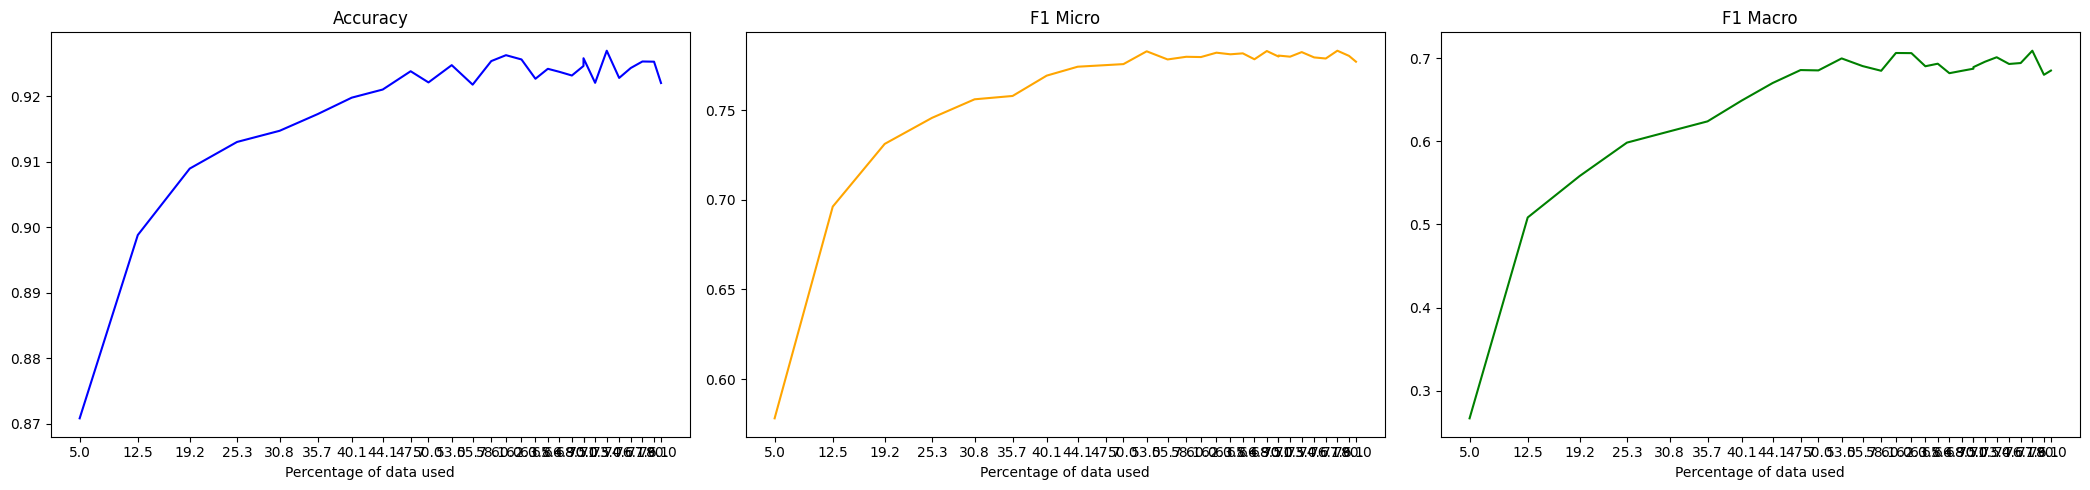

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6126, Accuracy: 0.8292, F1 Micro: 0.1246, F1 Macro: 0.0417
Epoch 2/10, Train Loss: 0.466, Accuracy: 0.8283, F1 Micro: 0.0135, F1 Macro: 0.006
Epoch 3/10, Train Loss: 0.4052, Accuracy: 0.8326, F1 Micro: 0.0744, F1 Macro: 0.0285
Epoch 4/10, Train Loss: 0.3854, Accuracy: 0.8366, F1 Micro: 0.1202, F1 Macro: 0.0461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3789, Accuracy: 0.846, F1 Micro: 0.2352, F1 Macro: 0.0831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.367, Accuracy: 0.8566, F1 Micro: 0.3727, F1 Macro: 0.1226
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3376, Accuracy: 0.8669, F1 Micro: 0.4634, F1 Macro: 0.2008
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8723, F1 Micro: 0.5046, F1 Macro: 0.2333
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2958, Accuracy: 0.875, F1 Micro: 0.5295, F1 Macro: 0.2488
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5539, Accuracy: 0.8325, F1 Micro: 0.1519, F1 Macro: 0.0544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4335, Accuracy: 0.8302, F1 Micro: 0.3861, F1 Macro: 0.1049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4131, Accuracy: 0.8509, F1 Micro: 0.4025, F1 Macro: 0.1372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3853, Accuracy: 0.8657, F1 Micro: 0.5065, F1 Macro: 0.2137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3599, Accuracy: 0.8816, F1 Micro: 0.6009, F1 Macro: 0.2876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3241, Accuracy: 0.8867, F1 Micro: 0.6277, F1 Macro: 0.3204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2874, Accuracy: 0.8927, F1 Micro: 0.6428, F1 Macro: 0.3878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2583, Accuracy: 0.8955, F1 Micro: 0.6671, F1 Macro: 0.4348
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5082, Accuracy: 0.8366, F1 Micro: 0.37, F1 Macro: 0.1036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4236, Accuracy: 0.84, F1 Micro: 0.3853, F1 Macro: 0.1136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3997, Accuracy: 0.8571, F1 Micro: 0.4639, F1 Macro: 0.167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.367, Accuracy: 0.888, F1 Micro: 0.6444, F1 Macro: 0.347
Epoch 5/10, Train Loss: 0.3206, Accuracy: 0.896, F1 Micro: 0.6327, F1 Macro: 0.3896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2773, Accuracy: 0.899, F1 Micro: 0.6978, F1 Macro: 0.4836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2398, Accuracy: 0.9045, F1 Micro: 0.7078, F1 Macro: 0.5059
Epoch 8/10, Train Loss: 0.2112, Accuracy: 0.9065, F1 Micro: 0.7076, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1827, Accuracy: 0.9058, F1 Micro: 0.7226, F1 Macro: 0.5226
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.497, Accuracy: 0.8237, F1 Micro: 0.3879, F1 Macro: 0.1038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4164, Accuracy: 0.8459, F1 Micro: 0.4394, F1 Macro: 0.1573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3772, Accuracy: 0.8854, F1 Micro: 0.6103, F1 Macro: 0.3618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3321, Accuracy: 0.9006, F1 Micro: 0.7023, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2857, Accuracy: 0.9047, F1 Micro: 0.7199, F1 Macro: 0.5346
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2395, Accuracy: 0.9079, F1 Micro: 0.7319, F1 Macro: 0.5508
Epoch 7/10, Train Loss: 0.2059, Accuracy: 0.9095, F1 Micro: 0.7317, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1741, Accuracy: 0.9114, F1 Micro: 0.7339, F1 Macro: 0.5686
Epoch 9/10, Train Loss: 0.1471, Accuracy: 0.9131, F1 Micro: 0.7335, F1 Macro: 0.5849
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4873, Accuracy: 0.8243, F1 Micro: 0.3944, F1 Macro: 0.1056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4143, Accuracy: 0.8547, F1 Micro: 0.4827, F1 Macro: 0.1858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3637, Accuracy: 0.8959, F1 Micro: 0.6705, F1 Macro: 0.4546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3237, Accuracy: 0.8969, F1 Micro: 0.716, F1 Macro: 0.5277
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2795, Accuracy: 0.9073, F1 Micro: 0.7337, F1 Macro: 0.5383
Epoch 6/10, Train Loss: 0.2308, Accuracy: 0.9137, F1 Micro: 0.7313, F1 Macro: 0.5449
Epoch 7/10, Train Loss: 0.1907, Accuracy: 0.9144, F1 Micro: 0.724, F1 Macro: 0.5419
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1608, Accuracy: 0.9165, F1 Micro: 0.7469, F1 Macro: 0.5959
Epoch 9/10, Train Loss: 0.1322, Accuracy: 0.9166, F1 Micro: 0.7416, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4787, Accuracy: 0.8307, F1 Micro: 0.4137, F1 Macro: 0.1257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4085, Accuracy: 0.8798, F1 Micro: 0.6088, F1 Macro: 0.3319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3537, Accuracy: 0.9023, F1 Micro: 0.6859, F1 Macro: 0.4894
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3006, Accuracy: 0.9078, F1 Micro: 0.7302, F1 Macro: 0.5437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2571, Accuracy: 0.9083, F1 Micro: 0.7446, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2207, Accuracy: 0.9144, F1 Micro: 0.7516, F1 Macro: 0.5963
Epoch 7/10, Train Loss: 0.18, Accuracy: 0.9174, F1 Micro: 0.749, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1535, Accuracy: 0.9201, F1 Micro: 0.7546, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1335, Accuracy: 0.9164, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.8374, F1 Micro: 0.4102, F1 Macro: 0.1339
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3913, Accuracy: 0.8899, F1 Micro: 0.6206, F1 Macro: 0.3768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3305, Accuracy: 0.9039, F1 Micro: 0.7142, F1 Macro: 0.5098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2839, Accuracy: 0.9119, F1 Micro: 0.7143, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2431, Accuracy: 0.9157, F1 Micro: 0.7256, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2031, Accuracy: 0.9156, F1 Micro: 0.7613, F1 Macro: 0.6234
Epoch 7/10, Train Loss: 0.1751, Accuracy: 0.9176, F1 Micro: 0.7556, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1419, Accuracy: 0.9208, F1 Micro: 0.7614, F1 Macro: 0.6512
Epoch 9/10, Train Loss: 0.1263, Accuracy: 0.918, F1 Micro: 0.7613, F1 Macro: 0.6585
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4674, Accuracy: 0.843, F1 Micro: 0.4094, F1 Macro: 0.1387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3741, Accuracy: 0.8963, F1 Micro: 0.6515, F1 Macro: 0.4339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3191, Accuracy: 0.9066, F1 Micro: 0.7286, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2693, Accuracy: 0.9144, F1 Micro: 0.7502, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2298, Accuracy: 0.9179, F1 Micro: 0.7613, F1 Macro: 0.603
Epoch 6/10, Train Loss: 0.188, Accuracy: 0.9206, F1 Micro: 0.7596, F1 Macro: 0.6224
Epoch 7/10, Train Loss: 0.1612, Accuracy: 0.9221, F1 Micro: 0.7602, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1343, Accuracy: 0.9235, F1 Micro: 0.7658, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1175, Accuracy: 0.9226, F1 Micro: 0.7682, F1 Macro: 0.6593
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4642, Accuracy: 0.8495, F1 Micro: 0.4161, F1 Macro: 0.1428
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3686, Accuracy: 0.8973, F1 Micro: 0.6844, F1 Macro: 0.4785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3047, Accuracy: 0.9122, F1 Micro: 0.7284, F1 Macro: 0.5642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2549, Accuracy: 0.9129, F1 Micro: 0.7562, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2165, Accuracy: 0.919, F1 Micro: 0.7606, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1865, Accuracy: 0.9195, F1 Micro: 0.7691, F1 Macro: 0.6454
Epoch 7/10, Train Loss: 0.1549, Accuracy: 0.9194, F1 Micro: 0.7606, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1344, Accuracy: 0.924, F1 Micro: 0.7753, F1 Macro: 0.6674
Epoch 9/10, Train Loss: 0.1094, Accuracy: 0.9222, F1 Micro: 0.7743, F1 Macro: 0.6882
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4594, Accuracy: 0.8576, F1 Micro: 0.4822, F1 Macro: 0.1907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3559, Accuracy: 0.8995, F1 Micro: 0.6894, F1 Macro: 0.4792
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2951, Accuracy: 0.9094, F1 Micro: 0.7304, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2547, Accuracy: 0.9201, F1 Micro: 0.7523, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2174, Accuracy: 0.9208, F1 Micro: 0.7662, F1 Macro: 0.611
Epoch 6/10, Train Loss: 0.179, Accuracy: 0.9222, F1 Micro: 0.7635, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1513, Accuracy: 0.9242, F1 Micro: 0.7672, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1272, Accuracy: 0.923, F1 Micro: 0.7736, F1 Macro: 0.6846
Epoch 9/10, Train Loss: 0.1086, Accuracy: 0.9224, F1 Micro: 0.7662, F1 Macro: 0.6868
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4539, Accuracy: 0.8634, F1 Micro: 0.5597, F1 Macro: 0.2622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3471, Accuracy: 0.9028, F1 Micro: 0.6878, F1 Macro: 0.4649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2858, Accuracy: 0.9144, F1 Micro: 0.7193, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2459, Accuracy: 0.9179, F1 Micro: 0.7432, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2037, Accuracy: 0.9215, F1 Micro: 0.7662, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1723, Accuracy: 0.9242, F1 Micro: 0.7697, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.1425, Accuracy: 0.9231, F1 Micro: 0.7672, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1198, Accuracy: 0.9235, F1 Micro: 0.7737, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1034, Accuracy: 0.9254, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4486, Accuracy: 0.8752, F1 Micro: 0.575, F1 Macro: 0.2818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3336, Accuracy: 0.9039, F1 Micro: 0.6986, F1 Macro: 0.4825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2729, Accuracy: 0.9109, F1 Micro: 0.7392, F1 Macro: 0.5596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2313, Accuracy: 0.9198, F1 Micro: 0.7582, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1936, Accuracy: 0.9215, F1 Micro: 0.7623, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1665, Accuracy: 0.92, F1 Micro: 0.7688, F1 Macro: 0.6443
Epoch 7/10, Train Loss: 0.1403, Accuracy: 0.9237, F1 Micro: 0.7686, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9236, F1 Micro: 0.7781, F1 Macro: 0.6972
Epoch 9/10, Train Loss: 0.1024, Accuracy: 0.9244, F1 Micro: 0.774, F1 Macro: 0.6923
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8811, F1 Micro: 0.5736, F1 Macro: 0.2958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3237, Accuracy: 0.9059, F1 Micro: 0.7012, F1 Macro: 0.5098
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2686, Accuracy: 0.9142, F1 Micro: 0.7373, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2239, Accuracy: 0.9204, F1 Micro: 0.7577, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1893, Accuracy: 0.922, F1 Micro: 0.766, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.9246, F1 Micro: 0.773, F1 Macro: 0.6877
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.9256, F1 Micro: 0.7695, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1149, Accuracy: 0.9229, F1 Micro: 0.775, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.9257, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8825, F1 Micro: 0.6086, F1 Macro: 0.2997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3224, Accuracy: 0.9049, F1 Micro: 0.7035, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2652, Accuracy: 0.9135, F1 Micro: 0.7437, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2224, Accuracy: 0.9218, F1 Micro: 0.7596, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.923, F1 Micro: 0.761, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1587, Accuracy: 0.9237, F1 Micro: 0.7816, F1 Macro: 0.6804
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.922, F1 Micro: 0.7767, F1 Macro: 0.6933
Epoch 8/10, Train Loss: 0.1143, Accuracy: 0.9218, F1 Micro: 0.7762, F1 Macro: 0.6918
Epoch 9/10, Train Loss: 0.0976, Accuracy: 0.9231, F1 Micro: 0.7802, F1 Macro: 0.6994
Epoch 10/10, Train Loss: 0.0838, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4308, Accuracy: 0.8829, F1 Micro: 0.6299, F1 Macro: 0.3145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.9063, F1 Micro: 0.7045, F1 Macro: 0.4913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2591, Accuracy: 0.9159, F1 Micro: 0.7346, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.9175, F1 Micro: 0.7602, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.9203, F1 Micro: 0.7712, F1 Macro: 0.6465
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9196, F1 Micro: 0.7657, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9259, F1 Micro: 0.7829, F1 Macro: 0.6955
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9224, F1 Micro: 0.7755, F1 Macro: 0.6907
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.9217, F1 Micro: 0.7763, F1 Macro: 0.7011
Epoch 10/10, Train Loss: 0.0818, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4259, Accuracy: 0.883, F1 Micro: 0.6312, F1 Macro: 0.3156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3093, Accuracy: 0.9065, F1 Micro: 0.715, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9169, F1 Micro: 0.7514, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.9183, F1 Micro: 0.7653, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9231, F1 Micro: 0.7707, F1 Macro: 0.6428
Epoch 6/10, Train Loss: 0.1525, Accuracy: 0.9237, F1 Micro: 0.7698, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1272, Accuracy: 0.925, F1 Micro: 0.7775, F1 Macro: 0.6696
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9221, F1 Micro: 0.7746, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0.9261, F1 Micro: 0.7804, F1 Macro: 0.6977
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.421, Accuracy: 0.8846, F1 Micro: 0.6066, F1 Macro: 0.3007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2989, Accuracy: 0.9069, F1 Micro: 0.7016, F1 Macro: 0.5216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.9133, F1 Micro: 0.7512, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9168, F1 Micro: 0.7641, F1 Macro: 0.6162
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.9186, F1 Micro: 0.7639, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9244, F1 Micro: 0.7726, F1 Macro: 0.662
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9247, F1 Micro: 0.7648, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9254, F1 Micro: 0.7729, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.9245, F1 Micro: 0.7773, F1 Macro: 0.7023
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4149, Accuracy: 0.8853, F1 Micro: 0.6127, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2914, Accuracy: 0.9067, F1 Micro: 0.7157, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9152, F1 Micro: 0.7237, F1 Macro: 0.5506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.9177, F1 Micro: 0.7626, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.9236, F1 Micro: 0.7769, F1 Macro: 0.6585
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9194, F1 Micro: 0.7757, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9244, F1 Micro: 0.7822, F1 Macro: 0.6984
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9253, F1 Micro: 0.7797, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.924, F1 Micro: 0.7784, F1 Macro: 0.7011
Epoch 10/10, Train Loss: 0.0746, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4139, Accuracy: 0.8866, F1 Micro: 0.6043, F1 Macro: 0.2977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2924, Accuracy: 0.9046, F1 Micro: 0.6804, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.9148, F1 Micro: 0.7425, F1 Macro: 0.553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9197, F1 Micro: 0.7697, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9238, F1 Micro: 0.7705, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9239, F1 Micro: 0.7781, F1 Macro: 0.6631
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9242, F1 Micro: 0.774, F1 Macro: 0.6838
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.925, F1 Micro: 0.7771, F1 Macro: 0.696
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.926, F1 Micro: 0.7766, F1 Macro: 0.709
Epoch 10/10, Train Loss: 0.0716, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4092, Accuracy: 0.8854, F1 Micro: 0.5838, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.9086, F1 Micro: 0.7101, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.9168, F1 Micro: 0.7517, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.9202, F1 Micro: 0.7639, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9255, F1 Micro: 0.779, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9237, F1 Micro: 0.7766, F1 Macro: 0.6846
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9222, F1 Micro: 0.7725, F1 Macro: 0.6699
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9211, F1 Micro: 0.7769, F1 Macro: 0.6942
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9248, F1 Micro: 0.7761, F1 Macro: 0.6941
Epoch 10/10, Train Loss: 0.0749, Accuracy: 0.9234, F1 Micro: 0.774, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4051, Accuracy: 0.887, F1 Micro: 0.6363, F1 Macro: 0.3527
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.9079, F1 Micro: 0.7179, F1 Macro: 0.5339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.9149, F1 Micro: 0.7536, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9219, F1 Micro: 0.7573, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9241, F1 Micro: 0.7684, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9245, F1 Micro: 0.7736, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.926, F1 Micro: 0.7768, F1 Macro: 0.6879
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9241, F1 Micro: 0.7736, F1 Macro: 0.6947
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9242, F1 Micro: 0.7751, F1 Macro: 0.7092
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8872, F1 Micro: 0.6082, F1 Macro: 0.3051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.9044, F1 Micro: 0.7216, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9161, F1 Micro: 0.7433, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.9187, F1 Micro: 0.7715, F1 Macro: 0.6246
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9249, F1 Micro: 0.7709, F1 Macro: 0.6623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9249, F1 Micro: 0.7758, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9244, F1 Micro: 0.7803, F1 Macro: 0.7019
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.923, F1 Micro: 0.7793, F1 Macro: 0.6938
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9208, F1 Micro: 0.7743, F1 Macro: 0.7007
Epoch 10/10, Train Loss: 0.0701, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8867, F1 Micro: 0.6307, F1 Macro: 0.3117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.9067, F1 Micro: 0.7118, F1 Macro: 0.5271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9163, F1 Micro: 0.7449, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9198, F1 Micro: 0.7621, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9171, F1 Micro: 0.7695, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9229, F1 Micro: 0.7791, F1 Macro: 0.6761
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9232, F1 Micro: 0.7752, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9241, F1 Micro: 0.7792, F1 Macro: 0.6949
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9249, F1 Micro: 0.7751, F1 Macro: 0.7002
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.8871, F1 Micro: 0.6122, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.9049, F1 Micro: 0.7132, F1 Macro: 0.4981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9164, F1 Micro: 0.7374, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9188, F1 Micro: 0.7609, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9252, F1 Micro: 0.7745, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9252, F1 Micro: 0.7763, F1 Macro: 0.6824
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9268, F1 Micro: 0.7826, F1 Macro: 0.6991
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9243, F1 Micro: 0.773, F1 Macro: 0.6923
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9221, F1 Micro: 0.7783, F1 Macro: 0.7068
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3859, Accuracy: 0.8875, F1 Micro: 0.6416, F1 Macro: 0.3398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9037, F1 Micro: 0.7237, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9169, F1 Micro: 0.751, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9217, F1 Micro: 0.7653, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9206, F1 Micro: 0.7734, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9188, F1 Micro: 0.7751, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9255, F1 Micro: 0.7778, F1 Macro: 0.6853
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9215, F1 Micro: 0.7733, F1 Macro: 0.6965
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9244, F1 Micro: 0.7765, F1 Macro: 0.7022
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.8837, F1 Micro: 0.5627, F1 Macro: 0.2829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.906, F1 Micro: 0.7164, F1 Macro: 0.5214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9172, F1 Micro: 0.7449, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9226, F1 Micro: 0.7697, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9234, F1 Micro: 0.7701, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9261, F1 Micro: 0.7793, F1 Macro: 0.6854
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9233, F1 Micro: 0.7793, F1 Macro: 0.6981
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9252, F1 Micro: 0.7773, F1 Macro: 0.699
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9239, F1 Micro: 0.7786, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.8859, F1 Micro: 0.6528, F1 Macro: 0.3422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9068, F1 Micro: 0.7102, F1 Macro: 0.4985
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.913, F1 Micro: 0.7541, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9223, F1 Micro: 0.7605, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9239, F1 Micro: 0.7737, F1 Macro: 0.6573
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9256, F1 Micro: 0.7736, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9233, F1 Micro: 0.7772, F1 Macro: 0.7015
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9226, F1 Micro: 0.7743, F1 Macro: 0.7019
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.924, F1 Micro: 0.7713, F1 Macro: 0.6862
Epoch 10/10, Train Loss: 0.0671, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8888, F1 Micro: 0.6321, F1 Macro: 0.3156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9071, F1 Micro: 0.7056, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9154, F1 Micro: 0.75, F1 Macro: 0.5754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.921, F1 Micro: 0.7618, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9234, F1 Micro: 0.7732, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9238, F1 Micro: 0.7766, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9239, F1 Micro: 0.7813, F1 Macro: 0.68
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9231, F1 Micro: 0.7711, F1 Macro: 0.6923
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9188, F1 Micro: 0.7714, F1 Macro: 0.7068
Epoch 10/

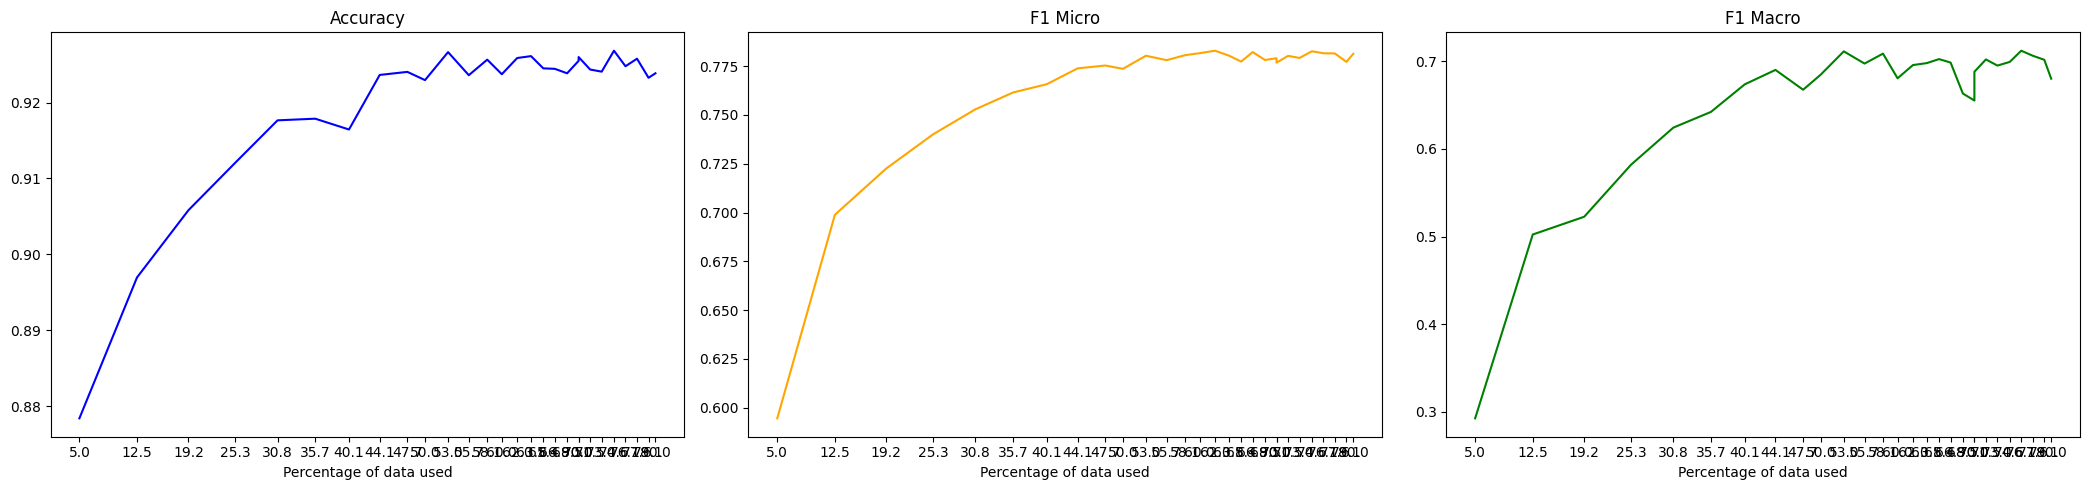

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6229, Accuracy: 0.8175, F1 Micro: 0.1735, F1 Macro: 0.084
Epoch 2/10, Train Loss: 0.4626, Accuracy: 0.8323, F1 Micro: 0.088, F1 Macro: 0.0328
Epoch 3/10, Train Loss: 0.4094, Accuracy: 0.8314, F1 Micro: 0.0611, F1 Macro: 0.0245
Epoch 4/10, Train Loss: 0.4066, Accuracy: 0.8369, F1 Micro: 0.1189, F1 Macro: 0.0463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3749, Accuracy: 0.8493, F1 Micro: 0.2718, F1 Macro: 0.0926
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3771, Accuracy: 0.858, F1 Micro: 0.3885, F1 Macro: 0.1306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3505, Accuracy: 0.8657, F1 Micro: 0.4924, F1 Macro: 0.2095
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3263, Accuracy: 0.8741, F1 Micro: 0.5344, F1 Macro: 0.2477
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2903, Accuracy: 0.8768, F1 Micro: 0.5831, F1 Macro: 0.2794
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.822, F1 Micro: 0.413, F1 Macro: 0.1085
Epoch 2/10, Train Loss: 0.4379, Accuracy: 0.8284, F1 Micro: 0.3728, F1 Macro: 0.1012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4142, Accuracy: 0.8453, F1 Micro: 0.4152, F1 Macro: 0.1183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3939, Accuracy: 0.8658, F1 Micro: 0.502, F1 Macro: 0.2183
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3629, Accuracy: 0.8842, F1 Micro: 0.6255, F1 Macro: 0.3596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3208, Accuracy: 0.8903, F1 Micro: 0.671, F1 Macro: 0.4274
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.285, Accuracy: 0.8938, F1 Micro: 0.687, F1 Macro: 0.4914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2464, Accuracy: 0.8976, F1 Micro: 0.6918, F1 Macro: 0.4864
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.211, Accuracy: 0.8995, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5097, Accuracy: 0.8233, F1 Micro: 0.3991, F1 Macro: 0.1058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4261, Accuracy: 0.831, F1 Micro: 0.4073, F1 Macro: 0.11
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3963, Accuracy: 0.8632, F1 Micro: 0.494, F1 Macro: 0.1941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3579, Accuracy: 0.8914, F1 Micro: 0.6568, F1 Macro: 0.3725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.32, Accuracy: 0.8994, F1 Micro: 0.6844, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.279, Accuracy: 0.9009, F1 Micro: 0.6977, F1 Macro: 0.5122
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2337, Accuracy: 0.9035, F1 Micro: 0.7225, F1 Macro: 0.5454
Epoch 8/10, Train Loss: 0.2049, Accuracy: 0.9051, F1 Micro: 0.7213, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1742, Accuracy: 0.9062, F1 Micro: 0.72

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4931, Accuracy: 0.8259, F1 Micro: 0.3823, F1 Macro: 0.1038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.418, Accuracy: 0.8467, F1 Micro: 0.4327, F1 Macro: 0.1438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3736, Accuracy: 0.8856, F1 Micro: 0.6236, F1 Macro: 0.3498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3257, Accuracy: 0.9007, F1 Micro: 0.6876, F1 Macro: 0.4798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2841, Accuracy: 0.9062, F1 Micro: 0.7114, F1 Macro: 0.4823
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2412, Accuracy: 0.9089, F1 Micro: 0.7396, F1 Macro: 0.559
Epoch 7/10, Train Loss: 0.2001, Accuracy: 0.9101, F1 Micro: 0.735, F1 Macro: 0.5601
Epoch 8/10, Train Loss: 0.1676, Accuracy: 0.9129, F1 Micro: 0.7257, F1 Macro: 0.5548
Epoch 9/10, Train Loss: 0.143, Accuracy: 0.9106, F1 Micro: 0.737, F1 Macro: 0.5759
Epoch 10/10, Train Loss: 0.1249, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.8358, F1 Micro: 0.3869, F1 Macro: 0.1079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4123, Accuracy: 0.8608, F1 Micro: 0.468, F1 Macro: 0.1813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3652, Accuracy: 0.8965, F1 Micro: 0.6759, F1 Macro: 0.451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3195, Accuracy: 0.9051, F1 Micro: 0.7134, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2704, Accuracy: 0.9085, F1 Micro: 0.7348, F1 Macro: 0.5497
Epoch 6/10, Train Loss: 0.2265, Accuracy: 0.9122, F1 Micro: 0.723, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.196, Accuracy: 0.9141, F1 Micro: 0.7424, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1628, Accuracy: 0.918, F1 Micro: 0.7541, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.139, Accuracy: 0.9185, F1 Micro: 0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4782, Accuracy: 0.8276, F1 Micro: 0.4026, F1 Macro: 0.1081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4014, Accuracy: 0.8819, F1 Micro: 0.6074, F1 Macro: 0.3237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3442, Accuracy: 0.8983, F1 Micro: 0.7047, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3031, Accuracy: 0.9098, F1 Micro: 0.7161, F1 Macro: 0.5329
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2567, Accuracy: 0.912, F1 Micro: 0.7314, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2148, Accuracy: 0.9168, F1 Micro: 0.7521, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1788, Accuracy: 0.9166, F1 Micro: 0.7573, F1 Macro: 0.6124
Epoch 8/10, Train Loss: 0.1488, Accuracy: 0.9122, F1 Micro: 0.7563, F1 Macro: 0.6235
Epoch 9/10, Train Loss: 0.1299, Accuracy: 0.9165, F1 Micro: 0.7515, F1 Macro: 0.6255
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4765, Accuracy: 0.8364, F1 Micro: 0.3962, F1 Macro: 0.1106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3952, Accuracy: 0.8873, F1 Micro: 0.6396, F1 Macro: 0.4178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3336, Accuracy: 0.9044, F1 Micro: 0.7198, F1 Macro: 0.5415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2887, Accuracy: 0.9131, F1 Micro: 0.7413, F1 Macro: 0.5787
Epoch 5/10, Train Loss: 0.2441, Accuracy: 0.9171, F1 Micro: 0.7402, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2036, Accuracy: 0.9185, F1 Micro: 0.7579, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1641, Accuracy: 0.9203, F1 Micro: 0.7643, F1 Macro: 0.6292
Epoch 8/10, Train Loss: 0.1412, Accuracy: 0.9205, F1 Micro: 0.7569, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1266, Accuracy: 0.9192, F1 Micro: 0.7647, F1 Macro: 0.6443
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4703, Accuracy: 0.8429, F1 Micro: 0.4134, F1 Macro: 0.1281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3791, Accuracy: 0.8849, F1 Micro: 0.672, F1 Macro: 0.4912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3213, Accuracy: 0.9079, F1 Micro: 0.7308, F1 Macro: 0.5672
Epoch 4/10, Train Loss: 0.2726, Accuracy: 0.9146, F1 Micro: 0.7307, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2338, Accuracy: 0.9186, F1 Micro: 0.7572, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1926, Accuracy: 0.9227, F1 Micro: 0.767, F1 Macro: 0.6251
Epoch 7/10, Train Loss: 0.1599, Accuracy: 0.9208, F1 Micro: 0.7612, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1366, Accuracy: 0.9215, F1 Micro: 0.7698, F1 Macro: 0.6575
Epoch 9/10, Train Loss: 0.1189, Accuracy: 0.9193, F1 Micro: 0.7693, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4651, Accuracy: 0.8525, F1 Micro: 0.467, F1 Macro: 0.1754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3666, Accuracy: 0.8986, F1 Micro: 0.6827, F1 Macro: 0.4879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3104, Accuracy: 0.9133, F1 Micro: 0.7416, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2565, Accuracy: 0.918, F1 Micro: 0.7548, F1 Macro: 0.5958
Epoch 5/10, Train Loss: 0.2146, Accuracy: 0.9197, F1 Micro: 0.751, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1759, Accuracy: 0.921, F1 Micro: 0.7642, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1538, Accuracy: 0.9199, F1 Micro: 0.7665, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1306, Accuracy: 0.9211, F1 Micro: 0.7709, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1116, Accuracy: 0.9203, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4627, Accuracy: 0.8529, F1 Micro: 0.4455, F1 Macro: 0.1622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3581, Accuracy: 0.8978, F1 Micro: 0.6493, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2966, Accuracy: 0.9127, F1 Micro: 0.7381, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2558, Accuracy: 0.9178, F1 Micro: 0.7593, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2155, Accuracy: 0.9213, F1 Micro: 0.7677, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9249, F1 Micro: 0.773, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.9238, F1 Micro: 0.7795, F1 Macro: 0.6896
Epoch 8/10, Train Loss: 0.1284, Accuracy: 0.9235, F1 Micro: 0.7699, F1 Macro: 0.6656
Epoch 9/10, Train Loss: 0.1071, Accuracy: 0.9234, F1 Micro: 0.7726, F1 Macro: 0.6917
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.8638, F1 Micro: 0.4868, F1 Macro: 0.1939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3484, Accuracy: 0.9018, F1 Micro: 0.6777, F1 Macro: 0.451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2887, Accuracy: 0.9141, F1 Micro: 0.7351, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2454, Accuracy: 0.917, F1 Micro: 0.754, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2044, Accuracy: 0.9208, F1 Micro: 0.7678, F1 Macro: 0.6216
Epoch 6/10, Train Loss: 0.1752, Accuracy: 0.9233, F1 Micro: 0.7666, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1453, Accuracy: 0.919, F1 Micro: 0.7674, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.128, Accuracy: 0.9231, F1 Micro: 0.772, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1043, Accuracy: 0.921, F1 Micro: 0.7752, F1 Macro: 0.6944
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4473, Accuracy: 0.8766, F1 Micro: 0.5935, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3353, Accuracy: 0.9034, F1 Micro: 0.7113, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2761, Accuracy: 0.9125, F1 Micro: 0.742, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2383, Accuracy: 0.9131, F1 Micro: 0.7549, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1943, Accuracy: 0.9231, F1 Micro: 0.7742, F1 Macro: 0.6432
Epoch 6/10, Train Loss: 0.1674, Accuracy: 0.9232, F1 Micro: 0.7684, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1426, Accuracy: 0.925, F1 Micro: 0.7766, F1 Macro: 0.673
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9245, F1 Micro: 0.7754, F1 Macro: 0.6835
Epoch 9/10, Train Loss: 0.0983, Accuracy: 0.9244, F1 Micro: 0.7735, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8775, F1 Micro: 0.5265, F1 Macro: 0.2464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3256, Accuracy: 0.9063, F1 Micro: 0.71, F1 Macro: 0.5286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2627, Accuracy: 0.9166, F1 Micro: 0.7451, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2193, Accuracy: 0.9195, F1 Micro: 0.7626, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1841, Accuracy: 0.9192, F1 Micro: 0.7701, F1 Macro: 0.6375
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.9224, F1 Micro: 0.7668, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.92, F1 Micro: 0.7714, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.925, F1 Micro: 0.7804, F1 Macro: 0.6975
Epoch 9/10, Train Loss: 0.0987, Accuracy: 0.921, F1 Micro: 0.7733, F1 Macro: 0.6966
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4329, Accuracy: 0.8834, F1 Micro: 0.6381, F1 Macro: 0.3491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3192, Accuracy: 0.9065, F1 Micro: 0.695, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2616, Accuracy: 0.9147, F1 Micro: 0.7508, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2191, Accuracy: 0.918, F1 Micro: 0.7624, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9215, F1 Micro: 0.7635, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1583, Accuracy: 0.9241, F1 Micro: 0.7709, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.924, F1 Micro: 0.7745, F1 Macro: 0.6833
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9203, F1 Micro: 0.7712, F1 Macro: 0.6847
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9208, F1 Micro: 0.7742, F1 Macro: 0.6918
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4312, Accuracy: 0.8824, F1 Micro: 0.5661, F1 Macro: 0.275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.313, Accuracy: 0.9054, F1 Micro: 0.6895, F1 Macro: 0.4513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2574, Accuracy: 0.9141, F1 Micro: 0.7389, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.9202, F1 Micro: 0.7602, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1809, Accuracy: 0.9219, F1 Micro: 0.7704, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.924, F1 Micro: 0.7731, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.9246, F1 Micro: 0.7735, F1 Macro: 0.6885
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9233, F1 Micro: 0.7728, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.924, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4223, Accuracy: 0.8863, F1 Micro: 0.6152, F1 Macro: 0.3382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3018, Accuracy: 0.9076, F1 Micro: 0.7075, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.9152, F1 Micro: 0.7521, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2088, Accuracy: 0.9214, F1 Micro: 0.757, F1 Macro: 0.5983
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.9207, F1 Micro: 0.7528, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1525, Accuracy: 0.9246, F1 Micro: 0.7731, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9235, F1 Micro: 0.7786, F1 Macro: 0.6817
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9258, F1 Micro: 0.7773, F1 Macro: 0.686
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.924, F1 Micro: 0.7699, F1 Macro: 0.6851
Epoch 10/10, Train Loss: 0.0812, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.8843, F1 Micro: 0.6431, F1 Macro: 0.3277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2936, Accuracy: 0.9067, F1 Micro: 0.7207, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9156, F1 Micro: 0.7456, F1 Macro: 0.5874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.208, Accuracy: 0.9202, F1 Micro: 0.7585, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.9194, F1 Micro: 0.7664, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1504, Accuracy: 0.9217, F1 Micro: 0.7747, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.924, F1 Micro: 0.775, F1 Macro: 0.6613
Epoch 8/10, Train Loss: 0.108, Accuracy: 0.9227, F1 Micro: 0.7726, F1 Macro: 0.6873
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.9218, F1 Micro: 0.7737, F1 Macro: 0.7003
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4142, Accuracy: 0.8859, F1 Micro: 0.6276, F1 Macro: 0.3202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2874, Accuracy: 0.9066, F1 Micro: 0.7212, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9153, F1 Micro: 0.7425, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9217, F1 Micro: 0.7585, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9226, F1 Micro: 0.7699, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9233, F1 Micro: 0.7714, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1242, Accuracy: 0.9241, F1 Micro: 0.7714, F1 Macro: 0.6678
Epoch 8/10, Train Loss: 0.1048, Accuracy: 0.9164, F1 Micro: 0.7646, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9208, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8865, F1 Micro: 0.6211, F1 Macro: 0.3324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.9083, F1 Micro: 0.7131, F1 Macro: 0.5287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.917, F1 Micro: 0.742, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9219, F1 Micro: 0.7672, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.9222, F1 Micro: 0.7722, F1 Macro: 0.6428
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9225, F1 Micro: 0.7694, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9219, F1 Micro: 0.7736, F1 Macro: 0.6791
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9218, F1 Micro: 0.7722, F1 Macro: 0.6918
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9244, F1 Micro: 0.7727, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.407, Accuracy: 0.8841, F1 Micro: 0.5745, F1 Macro: 0.2954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9067, F1 Micro: 0.7115, F1 Macro: 0.5124
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2285, Accuracy: 0.9173, F1 Micro: 0.7469, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9213, F1 Micro: 0.7625, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9252, F1 Micro: 0.7751, F1 Macro: 0.6374
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9243, F1 Micro: 0.7716, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9236, F1 Micro: 0.7777, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9255, F1 Micro: 0.7809, F1 Macro: 0.6894
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.923, F1 Micro: 0.7681, F1 Macro: 0.6882
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8873, F1 Micro: 0.6198, F1 Macro: 0.3107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2861, Accuracy: 0.9075, F1 Micro: 0.7068, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9168, F1 Micro: 0.7424, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.198, Accuracy: 0.9171, F1 Micro: 0.7628, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1609, Accuracy: 0.9243, F1 Micro: 0.7717, F1 Macro: 0.6314
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9201, F1 Micro: 0.7712, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.923, F1 Micro: 0.7769, F1 Macro: 0.6865
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9208, F1 Micro: 0.7762, F1 Macro: 0.6943
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9218, F1 Micro: 0.7738, F1 Macro: 0.693
Epoch 10/10, Train Loss: 0.0734, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8851, F1 Micro: 0.6372, F1 Macro: 0.3285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.905, F1 Micro: 0.6779, F1 Macro: 0.4937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9183, F1 Micro: 0.747, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9188, F1 Micro: 0.7653, F1 Macro: 0.6131
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9179, F1 Micro: 0.7652, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9254, F1 Micro: 0.7738, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9259, F1 Micro: 0.7754, F1 Macro: 0.6768
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9231, F1 Micro: 0.774, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.9226, F1 Micro: 0.7771, F1 Macro: 0.6986
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8867, F1 Micro: 0.628, F1 Macro: 0.3425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9081, F1 Micro: 0.7278, F1 Macro: 0.5338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.9165, F1 Micro: 0.7466, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.9203, F1 Micro: 0.7629, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.923, F1 Micro: 0.7722, F1 Macro: 0.6408
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9241, F1 Micro: 0.7688, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9227, F1 Micro: 0.7795, F1 Macro: 0.6878
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9188, F1 Micro: 0.7708, F1 Macro: 0.6865
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9238, F1 Micro: 0.775, F1 Macro: 0.6992
Epoch 10/10, Train Loss: 0.0701, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8879, F1 Micro: 0.6134, F1 Macro: 0.3205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9044, F1 Micro: 0.6906, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.916, F1 Micro: 0.7399, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9179, F1 Micro: 0.7663, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9224, F1 Micro: 0.7735, F1 Macro: 0.6328
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9216, F1 Micro: 0.7688, F1 Macro: 0.6703
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9206, F1 Micro: 0.7722, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9233, F1 Micro: 0.7743, F1 Macro: 0.671
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9206, F1 Micro: 0.7691, F1 Macro: 0.6954
Epoch 10/10, Train Loss: 0.07, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8888, F1 Micro: 0.6577, F1 Macro: 0.376
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9084, F1 Micro: 0.7103, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9089, F1 Micro: 0.7462, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9196, F1 Micro: 0.7637, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.919, F1 Micro: 0.7656, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9194, F1 Micro: 0.7717, F1 Macro: 0.6592
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9244, F1 Micro: 0.771, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9248, F1 Micro: 0.7723, F1 Macro: 0.6941
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9202, F1 Micro: 0.7719, F1 Macro: 0.7011
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8873, F1 Micro: 0.6099, F1 Macro: 0.3168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9066, F1 Micro: 0.7071, F1 Macro: 0.5377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9165, F1 Micro: 0.755, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9179, F1 Micro: 0.7611, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9224, F1 Micro: 0.7686, F1 Macro: 0.6348
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9242, F1 Micro: 0.767, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9244, F1 Micro: 0.7758, F1 Macro: 0.6754
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9178, F1 Micro: 0.7693, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9247, F1 Micro: 0.7781, F1 Macro: 0.7039
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8886, F1 Micro: 0.6304, F1 Macro: 0.3529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.9096, F1 Micro: 0.7131, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9125, F1 Micro: 0.7511, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9169, F1 Micro: 0.7627, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9245, F1 Micro: 0.7758, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9233, F1 Micro: 0.7634, F1 Macro: 0.6503
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9195, F1 Micro: 0.7737, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9248, F1 Micro: 0.7771, F1 Macro: 0.6944
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9223, F1 Micro: 0.7735, F1 Macro: 0.6872
Epoch 10/10, Train Loss: 0.0647, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8866, F1 Micro: 0.6618, F1 Macro: 0.3711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9052, F1 Micro: 0.7188, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.9166, F1 Micro: 0.7379, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9198, F1 Micro: 0.7597, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9251, F1 Micro: 0.7705, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9197, F1 Micro: 0.7722, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9231, F1 Micro: 0.774, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9231, F1 Micro: 0.7761, F1 Macro: 0.6963
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9195, F1 Micro:

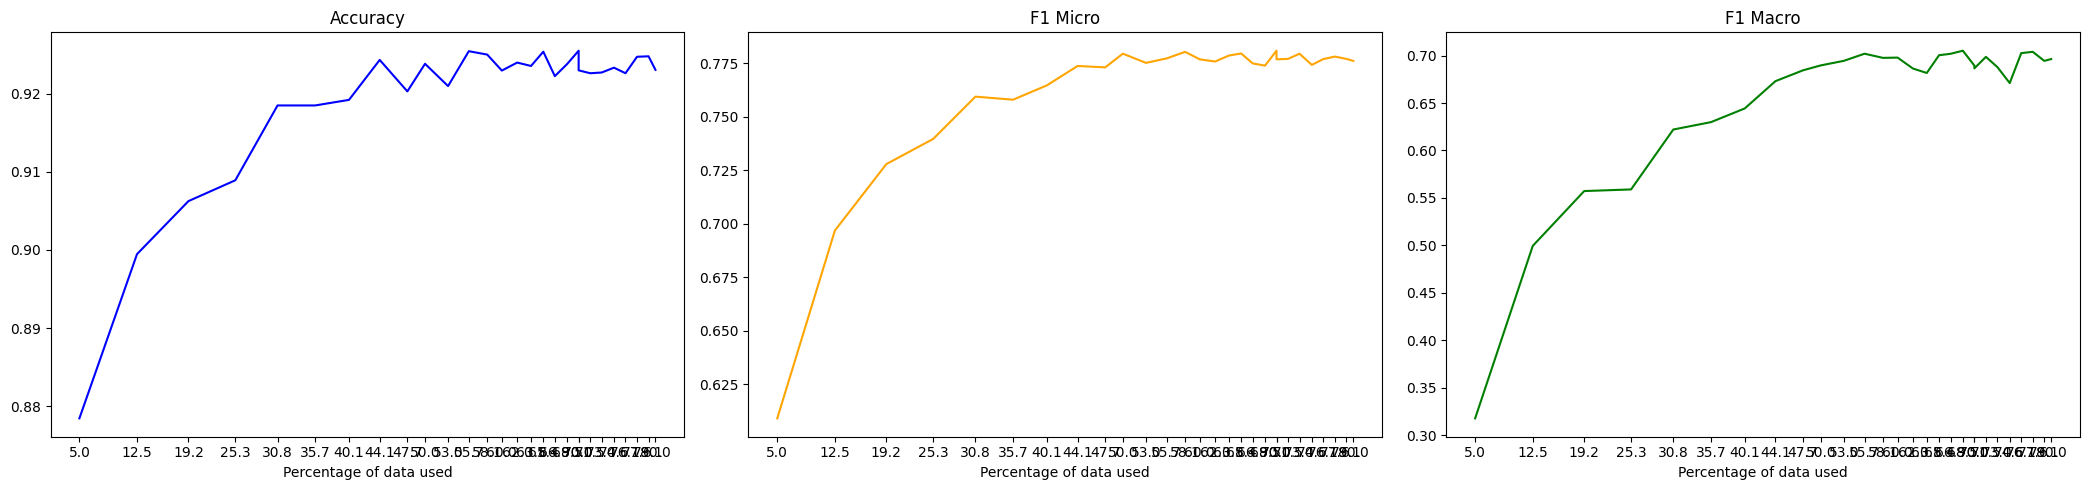

In [ ]:
active_learning(seeds[4], 4)